# Yelp Data Text Analysis and Modeling

This notebook demonstrates a complete pipeline for exploring, preprocessing, and modeling a subset of the Yelp dataset. The main objective is to predict whether a Yelp review is “more useful” or “less useful” based on both text and numeric features. We employ multiple classification techniques, including:

- Traditional machine learning models (Logistic Regression, Random Forest, etc.)
- Imbalanced-learning approaches (Cost-sensitive learning)
- Ensemble methods (AdaBoost, Stacking)
- Deep Learning architectures (BERT, LSTM, Multi-Input Models)

This notebook contains the following steps:

1. **Data Loading & Preprocessing**
2. **Exploratory Data Analysis (EDA)**
3. **Feature Engineering** (Numeric, Text, & Dimensionality Reduction)
4. **Model Training & Evaluation** (with cross-validation, metrics, and interpretability)
5. **Advanced Methods** (Imbalanced classification, ensembles, and deep learning approaches)

### Setup and Global Imports

In [8]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [9]:
import os
import sys
import numpy as np
import pandas as pd

os.chdir('/content/gdrive/MyDrive/utils')

# utils_path = os.path.join(os.getcwd(), "utils")
# if utils_path not in sys.path:
#     sys.path.append(utils_path)

# Import utility modules (preprocessing, plotting, modeling, etc.)
from preprocessing import (
    load_and_clean_data, transform_numeric_features, impute_binary_columns,
    TextTransformer, transform_text_features
)
from plotting import (
    plot_numeric_histograms, plot_categorical_bars, plot_target_distribution
)
from modeling import create_preprocessor
from ensemble import adacost_train, adacost_predict
from deep_learning import finetune_bert, build_lstm_model, build_multi_input_model
from evaluation import comprehensive_evaluation

# Additional libraries for modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import ADASYN

# Ensure tokenizer parallelism is disabled (for transformers)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## 1. Data Loading and Initial Cleaning

We begin by loading multiple raw Yelp JSON files (`review`, `user`, and `business`) into a **SQLite** database. This approach lets us select only relevant columns and neatly join the three tables, which contain review text, user attributes (e.g., fans, average_stars), and business details (e.g., parking/ambience attributes).

Next, we **expand** dictionary-like fields (e.g., `BusinessParking`, `Ambience`) into separate boolean columns and merge **ZIP code income data** from a Kaggle dataset. This step creates a richer feature space (e.g., a numeric `parking_count` and `region_income`). We also **filter** out average or low-usefulness reviews, retaining only “less useful” (< 40th percentile) and “more useful” (> 60th percentile) ones for clearer labeling.

Finally, the pipeline **consolidates** all information into a single CSV (`yelp_reduced.csv`). The `load_and_clean_data` function in `preprocessing.py` then removes columns irrelevant for modeling (IDs, etc.) and converts binary fields (like price range) to numeric codes, leaving a streamlined dataset ready for analysis.

In [10]:
# file_path = os.path.join("yelp_dataset", "yelp_reduced.csv")
file_path = "/content/gdrive/MyDrive/yelp_dataset/yelp_reduced.csv"
df = load_and_clean_data(file_path)

In [12]:
df = df.sample(frac=0.1)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111781 entries, 523069 to 128376
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   business_review_count   111781 non-null  int64  
 1   text                    111781 non-null  object 
 2   average_stars           111781 non-null  float64
 3   stars                   111781 non-null  float64
 4   business_stars          111781 non-null  float64
 5   user_review_count       111781 non-null  float64
 6   fans                    111781 non-null  float64
 7   useful_category         111781 non-null  object 
 8   user_total_votes        111781 non-null  float64
 9   user_total_compliments  111781 non-null  float64
 10  parking_count           111781 non-null  int64  
 11  region_income           111781 non-null  float64
 12  price_binary            85831 non-null   float64
 13  attire_binary           57887 non-null   float64
dtypes: float64(10), int6

From the output:
- The dataset includes numeric and object (text, useful_category) columns.
- Columns like `price_binary` and `attire_binary` have missing values.

## 2. Splitting Data into Features and Target

- We are predicting whether each Yelp review is “less useful” or “more useful,” stored in the `useful_category` column.
- We use a standard 80/20 train-test split with `stratify=y` to preserve class distribution in both sets.

In [14]:
X = df.drop(columns=['useful_category'])
y = df['useful_category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 3. Imputation for Binary Columns

We impute missing values in the `price_binary` and `attire_binary` columns using a KNN classifier. For each binary column, the KNN model is trained on rows where the column is known, using the other numeric features (excluding the text column) as predictors. Note that the KNN model is fit and validated on the train sets only. We then fill in the missing rows for both training and test sets with the KNN’s predictions. This approach leverages local similarity among rows to provide more data-driven imputation than a simple mean or mode fill, helping preserve valuable samples for downstream modeling.

In [15]:
binary_cols = ['price_binary', 'attire_binary']
X_train, X_test = impute_binary_columns(X_train, X_test, binary_cols)


Imputing missing values for: price_binary
CV scores for price_binary: [0.89798746 0.89878956 0.89622985 0.89870925 0.89571939]
Mean CV accuracy for price_binary: 0.8975
Remaining missing values in train for price_binary: 0
Remaining missing values in test for price_binary: 0

Imputing missing values for: attire_binary
CV scores for attire_binary: [0.95871609 0.95968439 0.95773887 0.9603329  0.9589278 ]
Mean CV accuracy for attire_binary: 0.9591
Remaining missing values in train for attire_binary: 0
Remaining missing values in test for attire_binary: 0


Outputs above shows cross-validation accuracies (90%+) for each binary column predictor and confirms no more missing values.

## 4. Exploratory Data Analysis (EDA)

- We look at **numerical features** (e.g., `business_review_count`, `average_stars`, etc.) to see if they are skewed or if there are outliers. If skewness is present, in the preprocessing we transform the skewed features.
- We look at **categorical features** (e.g., `stars`, `parking_count`, `price_binary`) to understand their frequency distribution.
- Finally, we look at our **target variable** distribution to check for imbalance—this can inform whether we need strategies like cost-sensitive learning or oversampling, or use models insensitive to class imbalance.

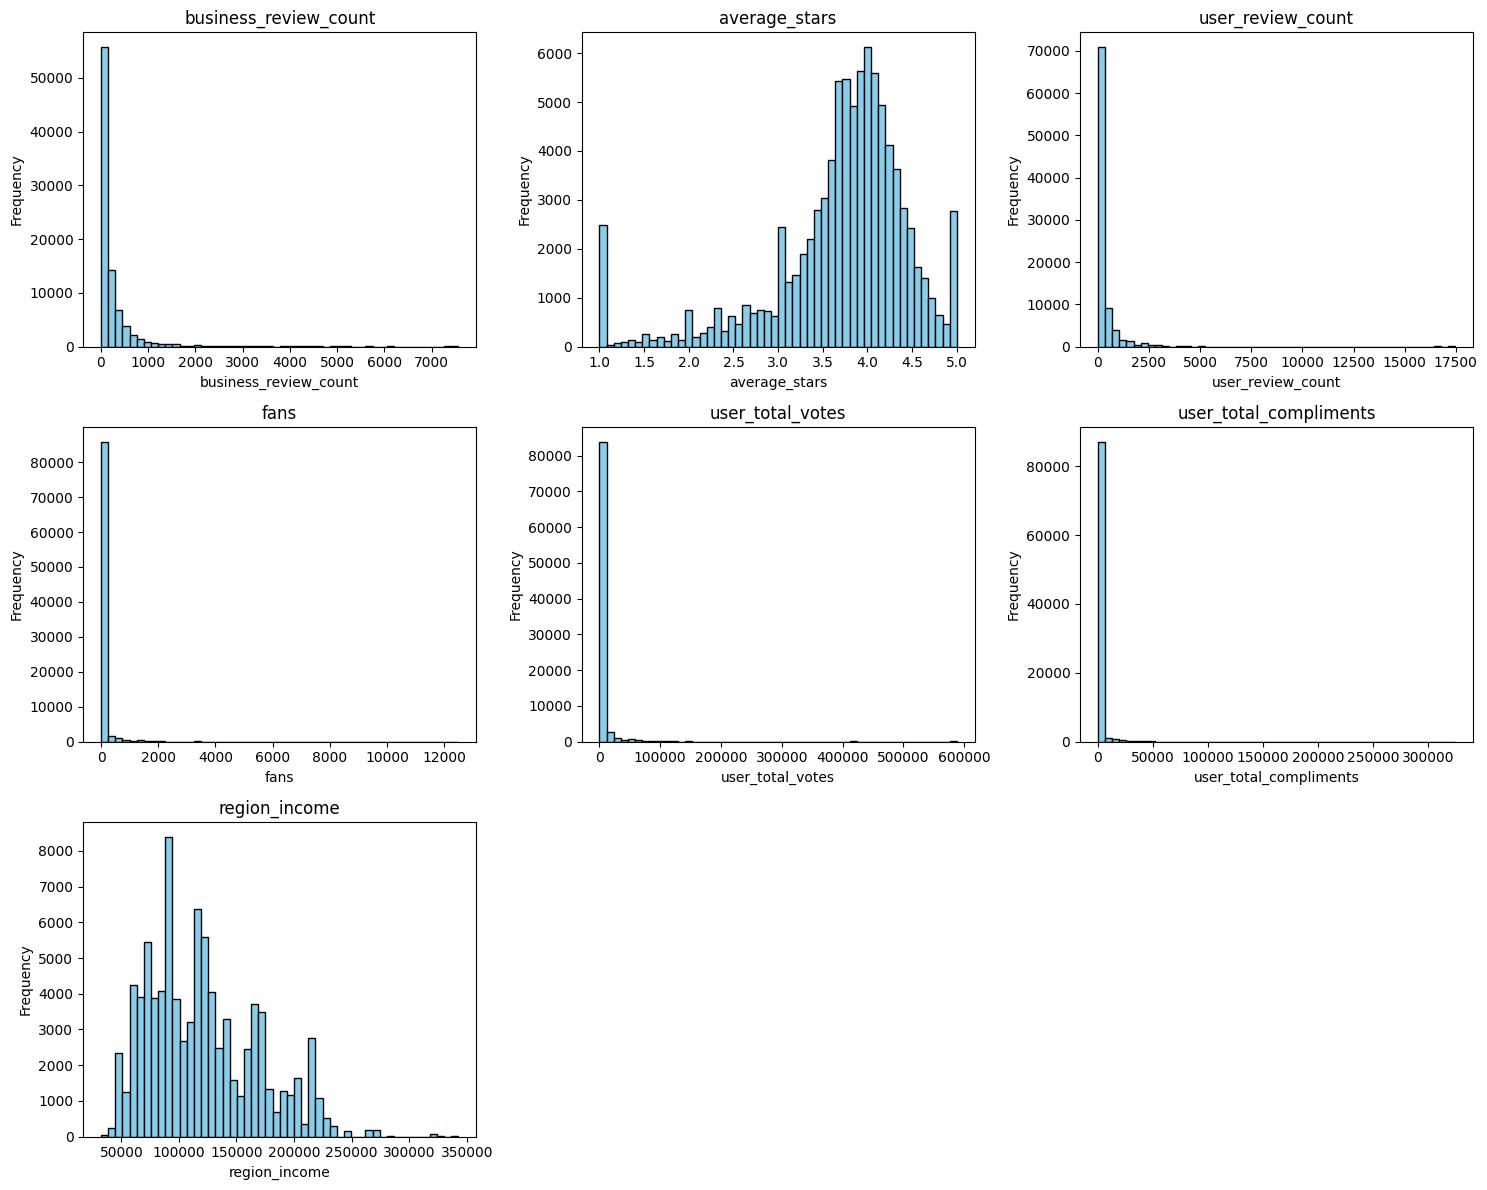

In [16]:
# Numeric Features Histogram
num_cols = ['business_review_count', 'average_stars', 'user_review_count',
            'fans', 'user_total_votes', 'user_total_compliments', 'region_income']
plot_numeric_histograms(X_train, num_cols)

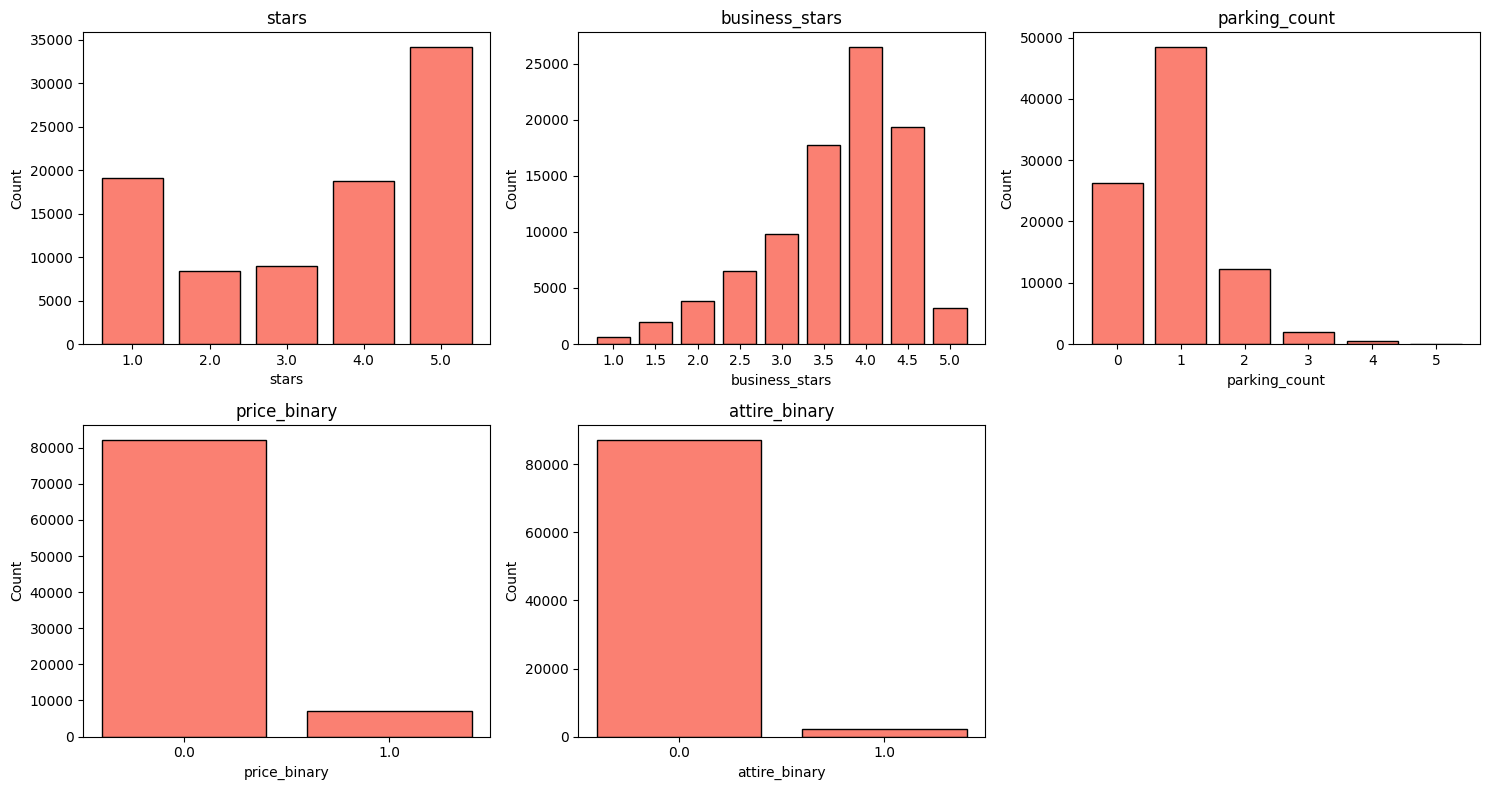

In [17]:
# Categorical Features Bar Charts
cat_cols = ['stars', 'business_stars', 'parking_count', 'price_binary', 'attire_binary']
plot_categorical_bars(X_train, cat_cols)

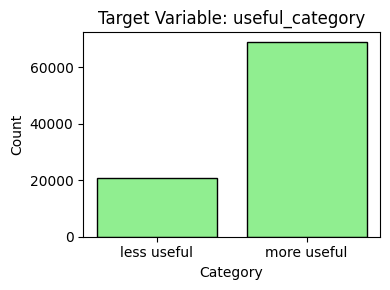

In [18]:
# Target Variable Distribution
plot_target_distribution(y_train, "Target Variable: useful_category")

## 5. Numeric Feature Transformation

- Many features exhibit **skewness** (e.g., `user_total_votes` can be heavily skewed, meaning most users have few votes, but a small percentage have very high counts).
- We apply **log-transform** to highly skewed features to mitigate extreme values and approximate a more normal distribution.
- We also scale the numeric features.
- This step typically helps models like Logistic Regression converge more reliably.

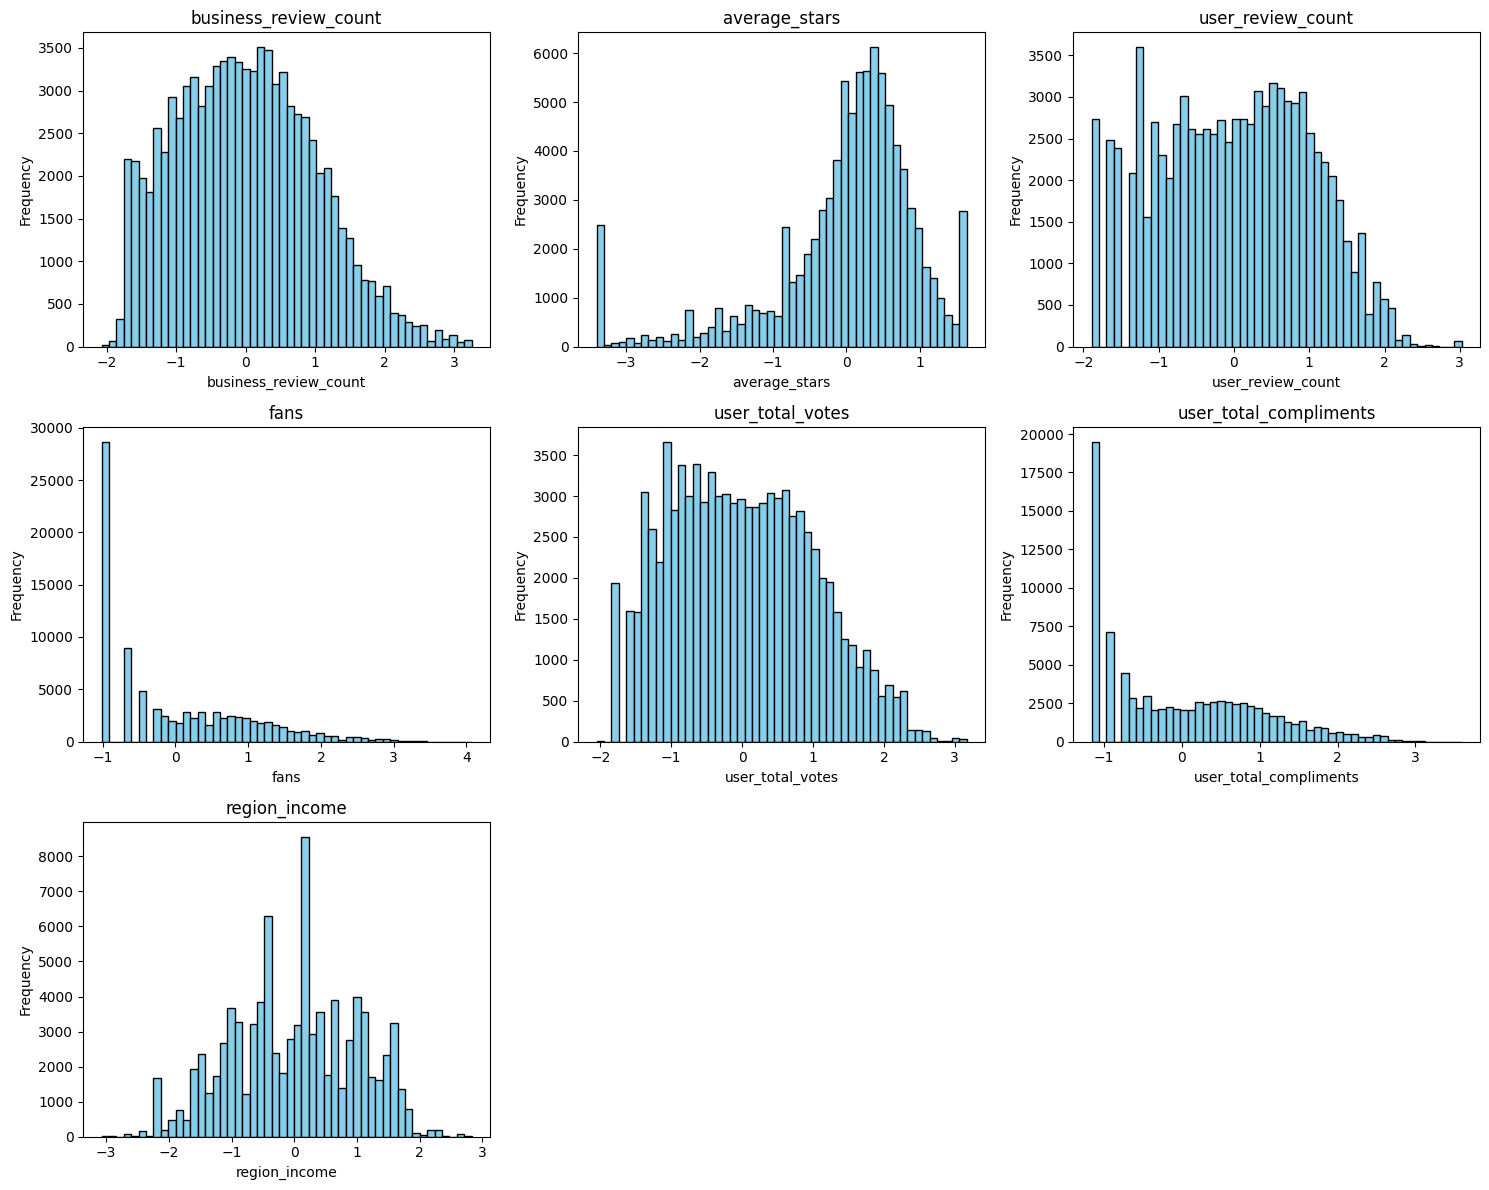

In [19]:
skewed_features = ['business_review_count', 'user_review_count', 'fans',
                   'user_total_votes', 'user_total_compliments', 'region_income']
numeric_features = ['average_stars', 'business_stars', 'parking_count']
stars_feature = ['stars']

X_train, X_test = transform_numeric_features(X_train, X_test, skewed_features, numeric_features, stars_feature)
plot_numeric_histograms(X_train, num_cols)

## 6. Text Feature Engineering

In TextTransformer, we:
- use sentence-level embeddings (SBERT).
- apply PCA (to reduce dimensionality).
- apply LDA (to capture thematic information).
- use TF-IDF vectorization to capture n-grams.

Balancing performance and dimensionality is key; we may not want thousands of raw n-gram features, so PCA helps keep a manageable size.

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV

# pipeline = Pipeline([
#     ('text_transformer', TextTransformer()),
#     ('classifier', LogisticRegression(max_iter=1000))
# ])

# # Define a grid to test different configurations:
# param_grid = {
#     'text_transformer__use_lda': [True, False],
#     'text_transformer__lda_topics': [5, 10],
#     'text_transformer__vectorizer_type': ['count', 'tfidf'],
#     # Experiment with unigrams vs. unigrams+bigrams
#     'text_transformer__ngram_range': [(1, 1), (1, 2)]
# }

# grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=0)
# grid.fit(X_train, y_train)

# print("Best parameters:", grid.best_params_)
# print("Best cross-validation accuracy:", grid.best_score_)

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob
from bertopic import BERTopic

class GPUTextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,
                 sbert_model_name: str = 'all-MiniLM-L6-v2',
                 use_topic_model: bool = True,  # Use BERTopic for topic extraction
                 topic_model_num: int = 100,        # Desired number of topics
                 count_max_features: int = 1000,
                 tfidf_max_features: int = 500,
                 vectorizer_type: str = 'tfidf',  # Options: 'count', 'tfidf', 'both'
                 ngram_range: tuple = (1, 2)):
        self.sbert_model_name = sbert_model_name
        self.use_topic_model = use_topic_model
        self.topic_model_num = topic_model_num
        self.count_max_features = count_max_features
        self.tfidf_max_features = tfidf_max_features
        self.vectorizer_type = vectorizer_type
        self.ngram_range = ngram_range

    def fit(self, X: pd.DataFrame, y=None):
        # Set up vectorizers based on vectorizer_type
        if self.vectorizer_type in ['count', 'both']:
            self.count_vectorizer_ = CountVectorizer(max_features=self.count_max_features,
                                                     stop_words='english',
                                                     ngram_range=self.ngram_range)
            self.count_vectorizer_.fit(X['text'])
        if self.vectorizer_type in ['tfidf', 'both']:
            self.tfidf_vectorizer_ = TfidfVectorizer(max_features=self.tfidf_max_features,
                                                     stop_words='english',
                                                     ngram_range=self.ngram_range)
            self.tfidf_vectorizer_.fit(X['text'])

        # Fit BERTopic for topic modeling if enabled
        if self.use_topic_model:
            self.topic_model_ = BERTopic(
                embedding_model=self.sbert_model_name,  # BERTopic accepts a model name directly
                nr_topics=self.topic_model_num,
                calculate_probabilities=True,
                verbose=True
            )
            texts = X['text'].tolist()
            topics, probs = self.topic_model_.fit_transform(texts)
        return self

    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        X_ = X.copy()
        # Extract sentiment feature using TextBlob
        X_['sentiment'] = X_['text'].apply(lambda txt: TextBlob(str(txt)).sentiment.polarity)

        # Use BERTopic to extract topic probabilities if enabled
        if self.use_topic_model:
            texts = X_['text'].tolist()
            topics, probs = self.topic_model_.transform(texts)
            if probs is not None:
                topic_cols = [f"topic_prob_{i}" for i in range(probs.shape[1])]
                df_topics = pd.DataFrame(probs, columns=topic_cols, index=X_.index)
                X_ = pd.concat([X_, df_topics], axis=1)
            else:
                X_['topic'] = topics

        # Add Count/Tfidf vectorizer features
        vectorizer_dfs = []
        if self.vectorizer_type in ['count', 'both']:
            count_features = self.count_vectorizer_.transform(X_['text'])
            count_cols = [f"count_{w}" for w in self.count_vectorizer_.get_feature_names_out()]
            df_count = pd.DataFrame(count_features.toarray(), columns=count_cols, index=X_.index)
            vectorizer_dfs.append(df_count)
        if self.vectorizer_type in ['tfidf', 'both']:
            tfidf_features = self.tfidf_vectorizer_.transform(X_['text'])
            tfidf_cols = [f"tfidf_{w}" for w in self.tfidf_vectorizer_.get_feature_names_out()]
            df_tfidf = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_cols, index=X_.index)
            vectorizer_dfs.append(df_tfidf)
        if vectorizer_dfs:
            df_vectorizers = pd.concat(vectorizer_dfs, axis=1)
            X_ = pd.concat([X_, df_vectorizers], axis=1)

        # Remove the original text column to avoid duplication
        X_.drop(columns=['text'], inplace=True)
        return X_

In [21]:
# text_transformer = TextTransformer(
#     sbert_model_name='all-MiniLM-L6-v2',
#     pca_components=200,
#     lda_topics=5,
#     vectorizer_type='tfidf',
#     tfidf_max_features=500,
#     ngram_range=(1, 2),
# )
text_transformer = GPUTextTransformer()
X_train_text, X_test_text = transform_text_features(X_train, X_test, y_train, text_transformer)
print("X_train_transformed shape:", X_train_text.shape)
print("X_test_transformed shape:", X_test_text.shape)

2025-03-03 18:50:32,229 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/280 [00:00<?, ?it/s]

2025-03-03 18:50:45,701 - BERTopic - Embedding - Completed ✓
2025-03-03 18:50:45,702 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-03 18:51:10,517 - BERTopic - Dimensionality - Completed ✓
2025-03-03 18:51:10,518 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-03 18:51:14,709 - BERTopic - Cluster - Completed ✓
2025-03-03 18:51:14,710 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-03 18:51:15,754 - BERTopic - Representation - Completed ✓
2025-03-03 18:51:15,755 - BERTopic - Topic reduction - Reducing number of topics
2025-03-03 18:51:16,784 - BERTopic - Topic reduction - Reduced number of topics from 106 to 100


Batches:   0%|          | 0/2795 [00:00<?, ?it/s]

2025-03-03 18:54:31,593 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-03-03 18:55:12,055 - BERTopic - Dimensionality - Completed ✓
2025-03-03 18:55:12,056 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-03-03 18:55:17,467 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-03-03 18:56:13,144 - BERTopic - Probabilities - Completed ✓
2025-03-03 18:56:13,144 - BERTopic - Cluster - Completed ✓


Batches:   0%|          | 0/699 [00:00<?, ?it/s]

2025-03-03 18:57:12,812 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-03-03 18:57:20,622 - BERTopic - Dimensionality - Completed ✓
2025-03-03 18:57:20,623 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-03-03 18:57:22,001 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-03-03 18:57:35,807 - BERTopic - Probabilities - Completed ✓
2025-03-03 18:57:35,807 - BERTopic - Cluster - Completed ✓


X_train_transformed shape: (89424, 612)
X_test_transformed shape: (22357, 612)


To-do: after combining numeric features, textual embeddings, and dimensionality reduction, there are xx columns.

## 7. Preprocessing for Modeling

We create a preprocessor that likely does scaling and one-hot encoding. Then we transform the entire training and test sets using that pipeline.

In [22]:
original_cols = list(X_train_text.columns)
preprocessor = create_preprocessor(X_train_text)
X_train_ready = preprocessor.fit_transform(X_train_text)
X_test_ready = preprocessor.transform(X_test_text)
print("X_train_ready shape:", X_train_ready.shape)
print("X_test_ready shape:", X_test_ready.shape)

X_train_ready shape: (89424, 612)
X_test_ready shape: (22357, 612)


## 8. Classic Machine Learning Models

- We start with Logistic Regression without using text features at all as a baseline.
- Then we measure performance with the custom comprehensive_evaluation function, which:
    * Prints classification metrics (precision, recall, F1, accuracy).
    * Performs cross-validation with the chosen scoring metric.
    * Optionally provides interpretability with LIME or SHAP, showing feature importances or local explanations.

We also use other algorithms like Random Forest to see if the F1 score or recall improves.

### 8.1 Baseline Logistic Regression (Numeric Only Example)

In [23]:
log_reg = LogisticRegression(C=0.0001, penalty='l2', solver='liblinear')
X_train_num = X_train.drop(columns='text', axis=1)
X_test_num = X_test.drop(columns='text', axis=1)
log_reg.fit(X_train_num, y_train)

LogisticRegression(C=0.0001, solver='liblinear')

Plotting learning curve...


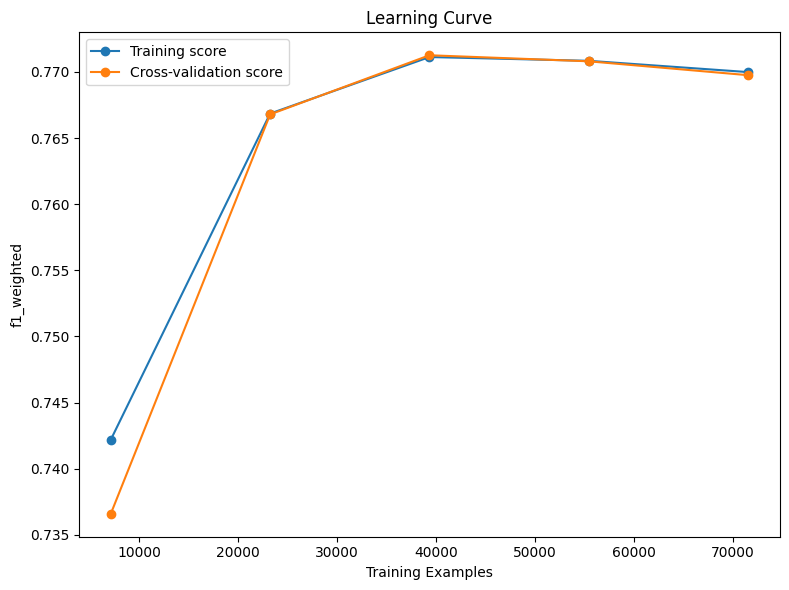


Evaluating on training data:
              precision    recall  f1-score   support

 less useful     0.5944    0.3231    0.4186     20606
 more useful     0.8217    0.9340    0.8742     68818

    accuracy                         0.7932     89424
   macro avg     0.7081    0.6285    0.6464     89424
weighted avg     0.7693    0.7932    0.7693     89424


Evaluating on test data:
              precision    recall  f1-score   support

 less useful     0.5919    0.3212    0.4165      5152
 more useful     0.8212    0.9337    0.8739     17205

    accuracy                         0.7925     22357
   macro avg     0.7066    0.6275    0.6452     22357
weighted avg     0.7684    0.7925    0.7684     22357



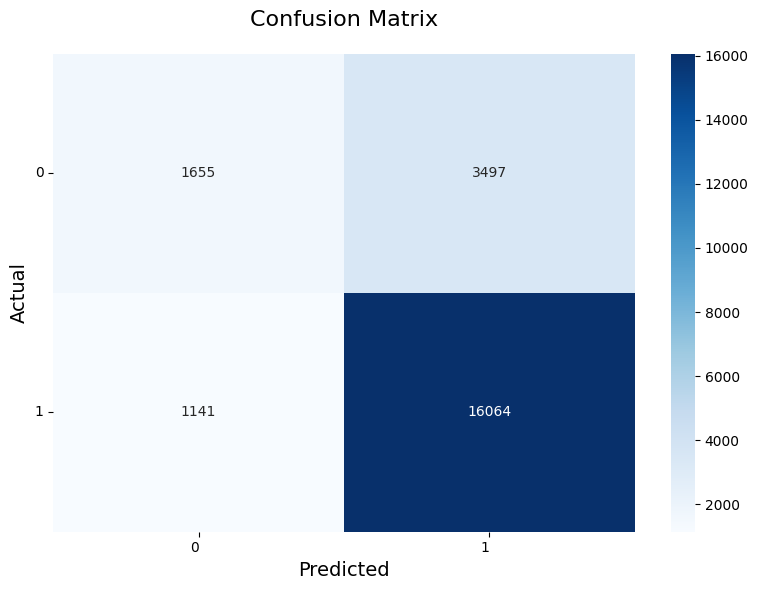

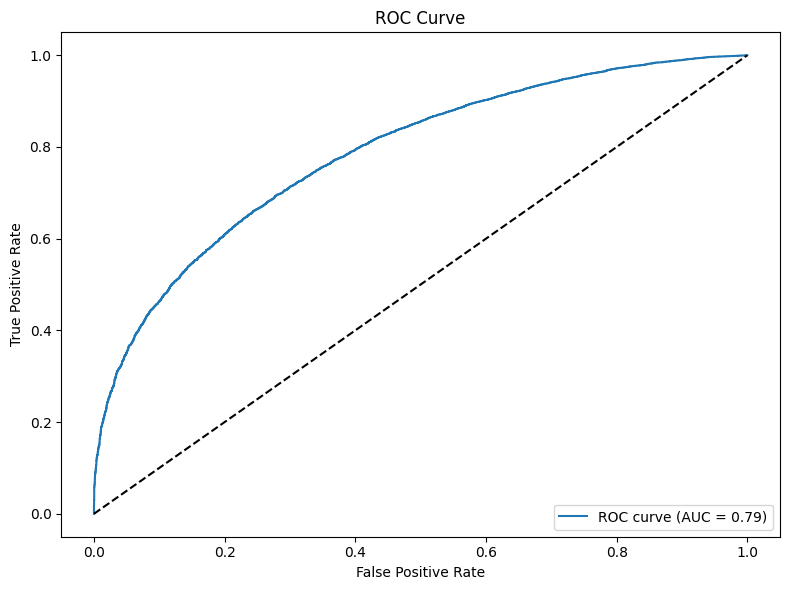

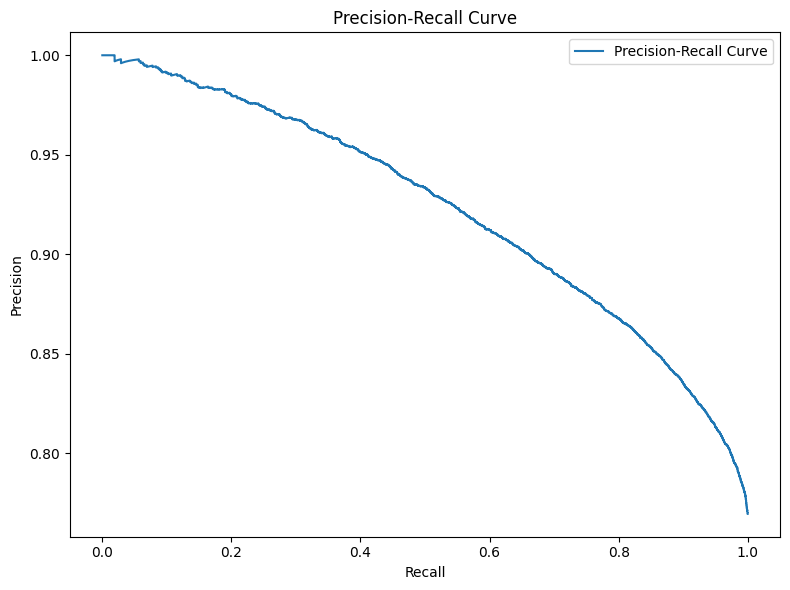

No feature importance attribute found for this model.
LIME Explanations for 10 Test Instances

--------------------------------------------------------------------------------
Instance 0 - Predicted Class: less useful
Original Text:
this place is the best place in levittown. it dont look like much on the outside or in but the food, service and prices are unbelievable. they only take cash though but it cant be beat. crab cakes are the best i have ever had!!
Top 10 Features and Their Contribution Scores:
                               Feature  Contribution
             user_total_votes <= -0.80     -0.099674
                  0.35 < stars <= 0.98     -0.059581
       user_total_compliments <= -0.90     -0.048669
-0.78 < business_review_count <= -0.04     -0.026313
                         fans <= -1.02     -0.012256
            user_review_count <= -0.80     -0.010655
        -0.81 < business_stars <= 0.41      0.009286
                 attire_binary <= 0.00     -0.009048
               

In [24]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
comprehensive_evaluation(log_reg, X_train_num, y_train, X_test_num, y_test,
                         model_type='sklearn', feature_names=original_cols, cv=5, scoring="f1_weighted", n_jobs=-1,
                         original_X_train=X_train, original_X_test=X_test)

### 8.2 Logistic Regression with Text + Numeric Features

(TO-do: check)
Usually, including text features substantially improves model performance, because the text provides direct cues about the sentiment and details of the user’s experience.
The LIME explanations show which words or embedding components push the classifier towards predicting “more useful” or “less useful.”

In [25]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C=0.001, penalty='l2', solver='liblinear')
log_reg.fit(X_train_ready, y_train)

LogisticRegression(C=0.001, solver='liblinear')

Plotting learning curve...


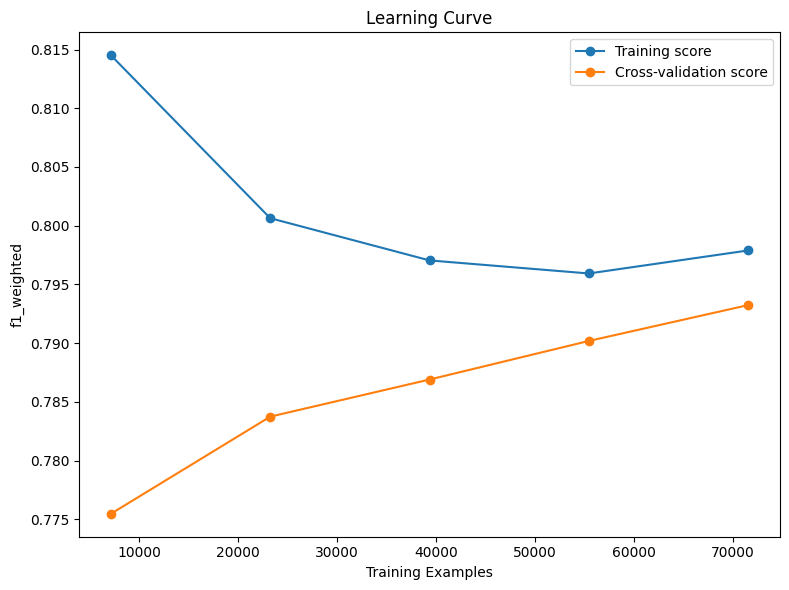


Evaluating on training data:
              precision    recall  f1-score   support

 less useful     0.6677    0.4056    0.5046     20606
 more useful     0.8407    0.9396    0.8874     68818

    accuracy                         0.8165     89424
   macro avg     0.7542    0.6726    0.6960     89424
weighted avg     0.8009    0.8165    0.7992     89424


Evaluating on test data:
              precision    recall  f1-score   support

 less useful     0.6517    0.3868    0.4855      5152
 more useful     0.8363    0.9381    0.8843     17205

    accuracy                         0.8111     22357
   macro avg     0.7440    0.6625    0.6849     22357
weighted avg     0.7938    0.8111    0.7924     22357



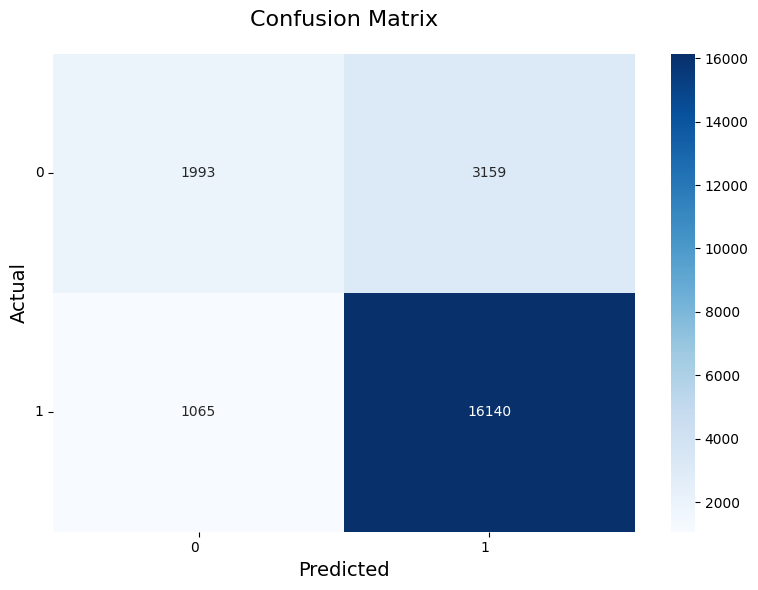

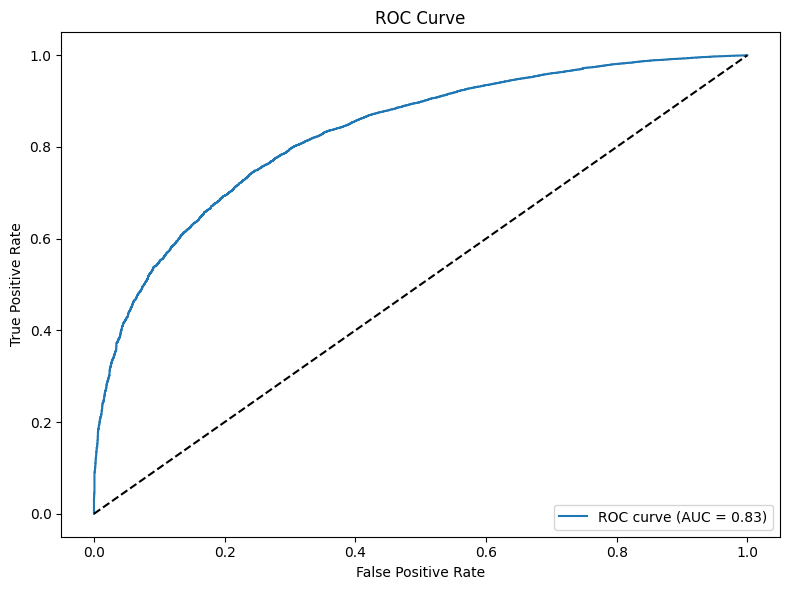

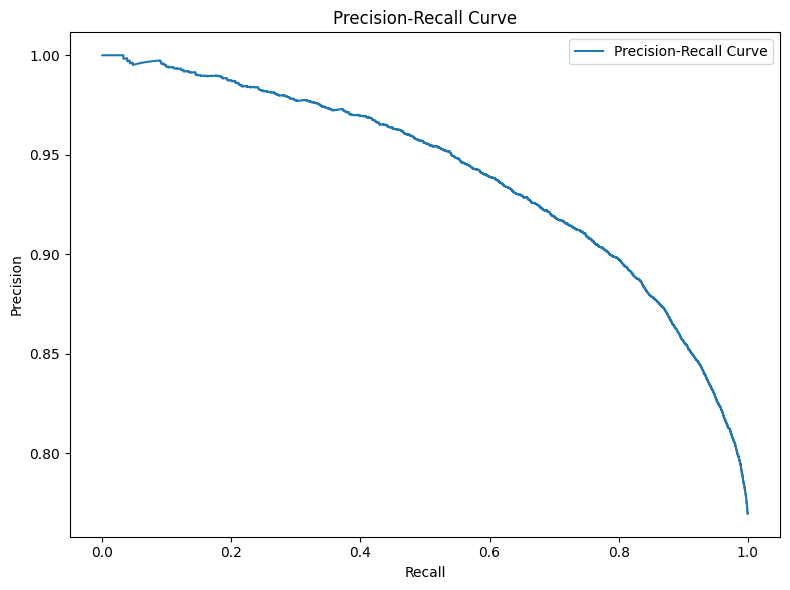

No feature importance attribute found for this model.
LIME Explanations for 10 Test Instances

--------------------------------------------------------------------------------
Instance 0 - Predicted Class: more useful
Original Text:
this place is the best place in levittown. it dont look like much on the outside or in but the food, service and prices are unbelievable. they only take cash though but it cant be beat. crab cakes are the best i have ever had!!
Top 10 Features and Their Contribution Scores:
                   Feature  Contribution
 user_total_votes <= -0.80     -0.158596
user_review_count <= -0.80      0.064068
      0.35 < stars <= 0.98     -0.044521
 tfidf_management <= -0.12     -0.036627
      tfidf_pizza <= -0.19     -0.030012
    attire_binary <= -0.16      0.029285
      tfidf_vegan <= -0.10     -0.029089
      tfidf_wings <= -0.13     -0.029054
      tfidf_sushi <= -0.13     -0.028427
     tfidf_waiter <= -0.14     -0.024559
-----------------------------------------

In [26]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
comprehensive_evaluation(log_reg, X_train_ready, y_train, X_test_ready, y_test,
                         model_type='sklearn', feature_names=original_cols, cv=5, scoring="f1_weighted", n_jobs=-1,
                         original_X_train=X_train, original_X_test=X_test)

### 8.3 Random Forest Model & Tuning

Random Forests often handle high-dimensional data well and can naturally rank feature importances. The pipeline approach with PCA further reduces dimension.
Here, the pipeline uses tuned hyperparameters with a PCA(n_components=100) and a RandomForestClassifier.

In [28]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

# Define the best pipeline based on grid search results
best_rf = ImbPipeline([
    ('sampler', 'passthrough'),
    ('pca', PCA(n_components=100)),
    ('clf', RandomForestClassifier(
        n_estimators=80,
        max_depth=10,
        min_samples_split=10,
        class_weight='balanced',
        random_state=42
    ))
])
best_rf.fit(X_train_ready, y_train)

Pipeline(steps=[('sampler', 'passthrough'), ('pca', PCA(n_components=100)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_split=10, n_estimators=80,
                                        random_state=42))])

Plotting learning curve...


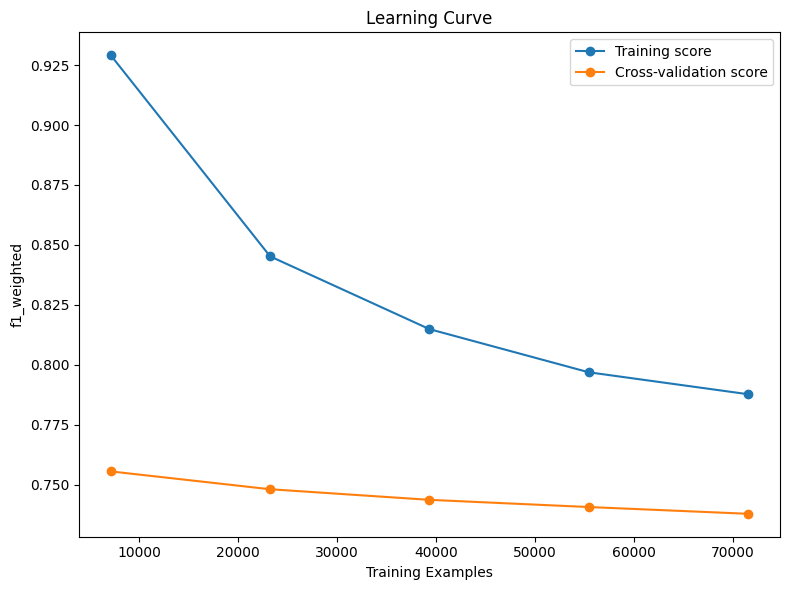


Evaluating on training data:
              precision    recall  f1-score   support

 less useful     0.4965    0.7901    0.6098     20606
 more useful     0.9236    0.7601    0.8339     68818

    accuracy                         0.7670     89424
   macro avg     0.7100    0.7751    0.7218     89424
weighted avg     0.8252    0.7670    0.7823     89424


Evaluating on test data:
              precision    recall  f1-score   support

 less useful     0.4339    0.6722    0.5274      5152
 more useful     0.8825    0.7374    0.8035     17205

    accuracy                         0.7224     22357
   macro avg     0.6582    0.7048    0.6654     22357
weighted avg     0.7791    0.7224    0.7398     22357



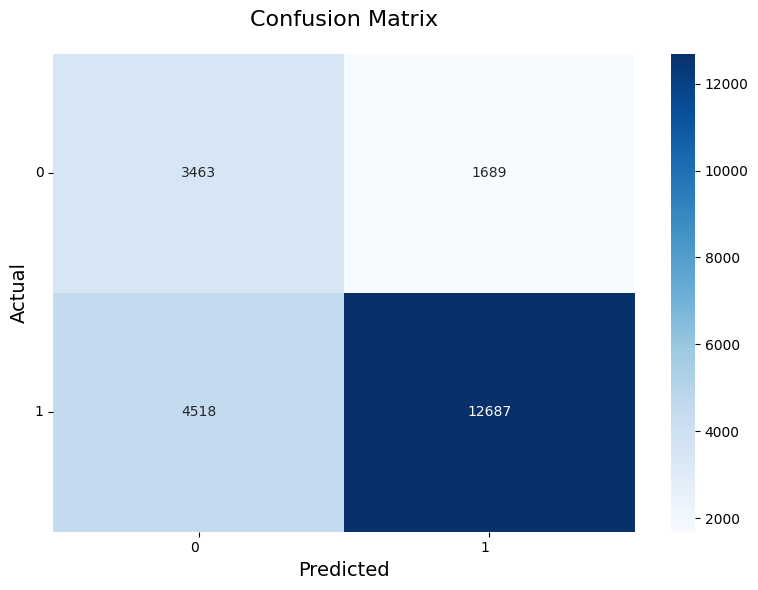

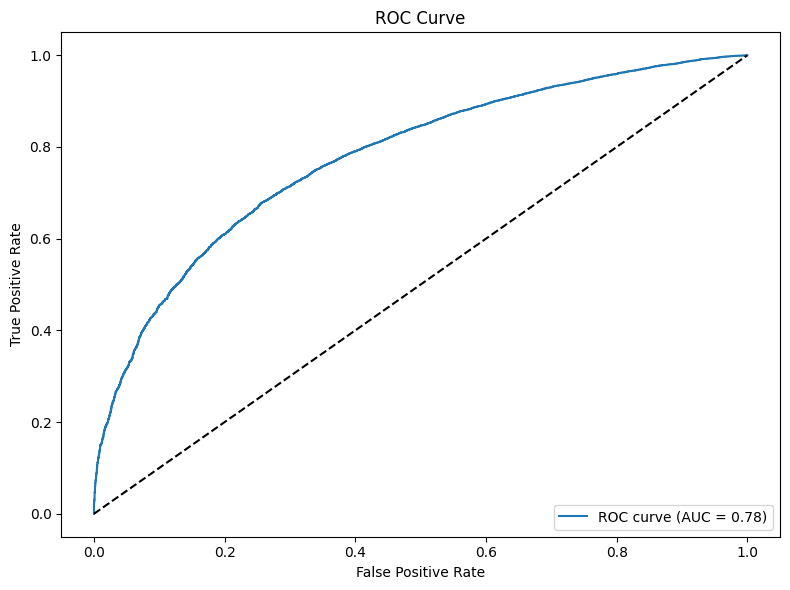

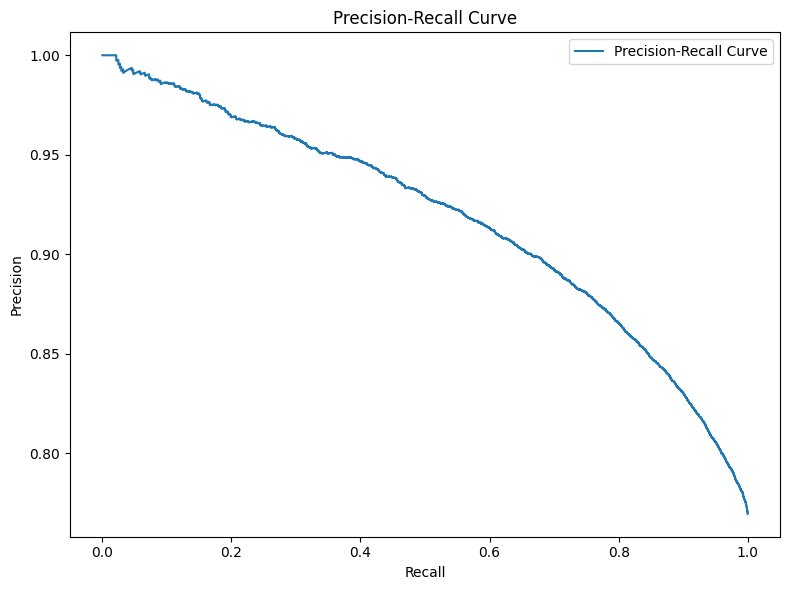

Plotting feature importances from pipeline...


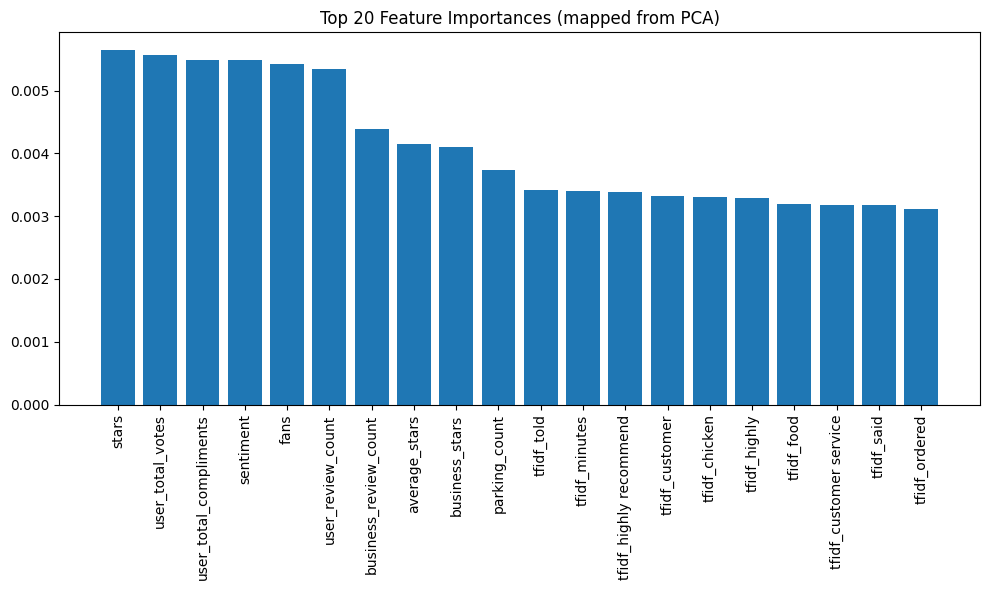

LIME Explanations for 10 Test Instances

--------------------------------------------------------------------------------
Instance 0 - Predicted Class: less useful
Original Text:
this place is the best place in levittown. it dont look like much on the outside or in but the food, service and prices are unbelievable. they only take cash though but it cant be beat. crab cakes are the best i have ever had!!
Top 10 Features and Their Contribution Scores:
                        Feature  Contribution
      user_total_votes <= -0.80     -0.042716
     user_review_count <= -0.80     -0.039560
         tfidf_mexican <= -0.12     -0.035743
user_total_compliments <= -0.90     -0.033667
              tfidf_dr <= -0.12      0.030159
           tfidf_nails <= -0.10     -0.029827
       tfidf_breakfast <= -0.18     -0.028588
           tfidf_tacos <= -0.13     -0.027603
        tfidf_don know <= -0.16     -0.020831
          tfidf_crispy <= -0.15     -0.020554
----------------------------------------

In [29]:
comprehensive_evaluation(best_rf, X_train_ready, y_train, X_test_ready, y_test,
                         model_type='sklearn', feature_names=original_cols, cv=5, scoring="f1_weighted", n_jobs=-1,
                         original_X_train=X_train, original_X_test=X_test)

## 9. Cost-Sensitive and Ensemble Methods

Because “more useful” reviews may dominate the dataset, plain accuracy can be misleading. We use:
1. **Cost-Sensitive classification** (e.g., `class_weight='balanced'` in RandomForest).
2. **Oversampling** or **synthetic sample generation** (ADASYN, SMOTE) to handle minority classes.
3. **Ensemble** methods like AdaBoost, Stacking, or Bagging to combine the strengths of multiple base learners.
This section explores how shifting the training distribution or weighting classes can affect recall on the minority class (“less useful”).

In [30]:
clf_cost_sensitive = RandomForestClassifier(
    n_estimators=80,
    max_depth=10,
    min_samples_split=10,
    class_weight='balanced',
    random_state=42
)
clf_cost_sensitive.fit(X_train_ready, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=10, n_estimators=80, random_state=42)

Plotting learning curve...


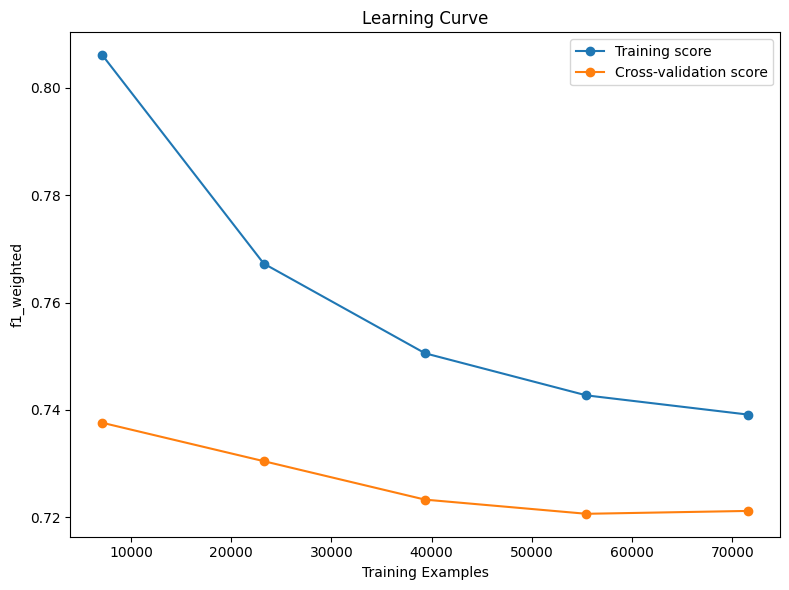


Evaluating on training data:
              precision    recall  f1-score   support

 less useful     0.4321    0.8022    0.5616     20606
 more useful     0.9204    0.6843    0.7849     68818

    accuracy                         0.7114     89424
   macro avg     0.6762    0.7432    0.6733     89424
weighted avg     0.8078    0.7114    0.7335     89424


Evaluating on test data:
              precision    recall  f1-score   support

 less useful     0.4122    0.7535    0.5329      5152
 more useful     0.9019    0.6783    0.7743     17205

    accuracy                         0.6956     22357
   macro avg     0.6570    0.7159    0.6536     22357
weighted avg     0.7890    0.6956    0.7186     22357



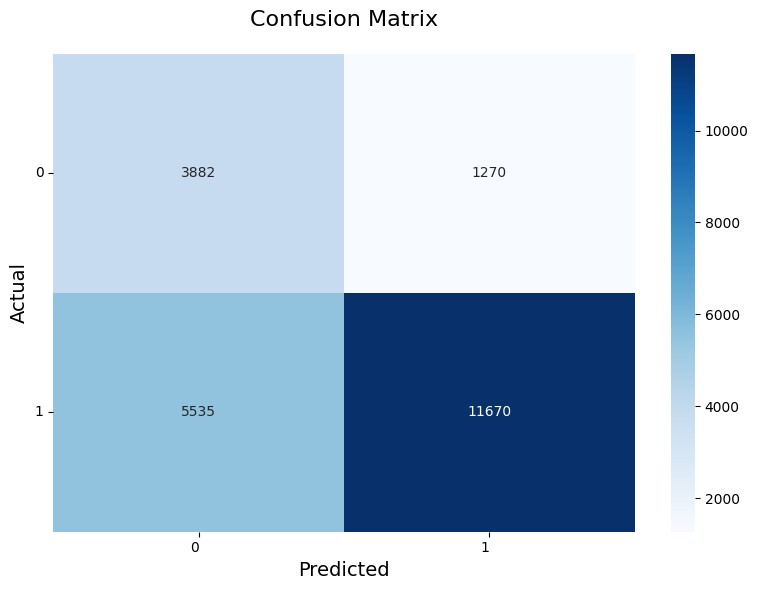

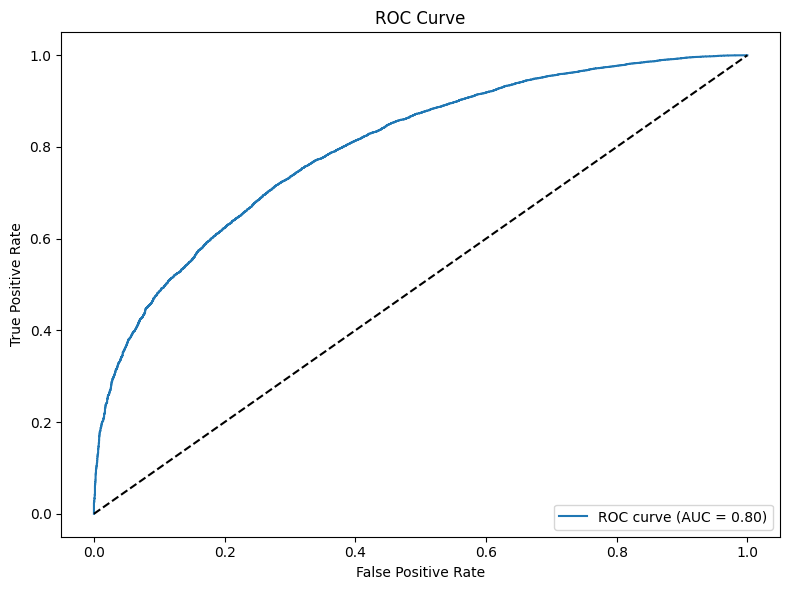

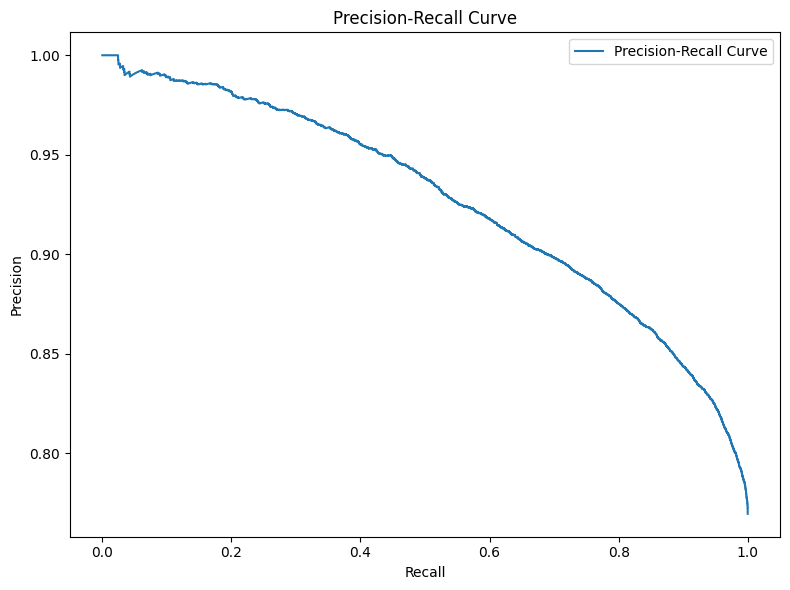

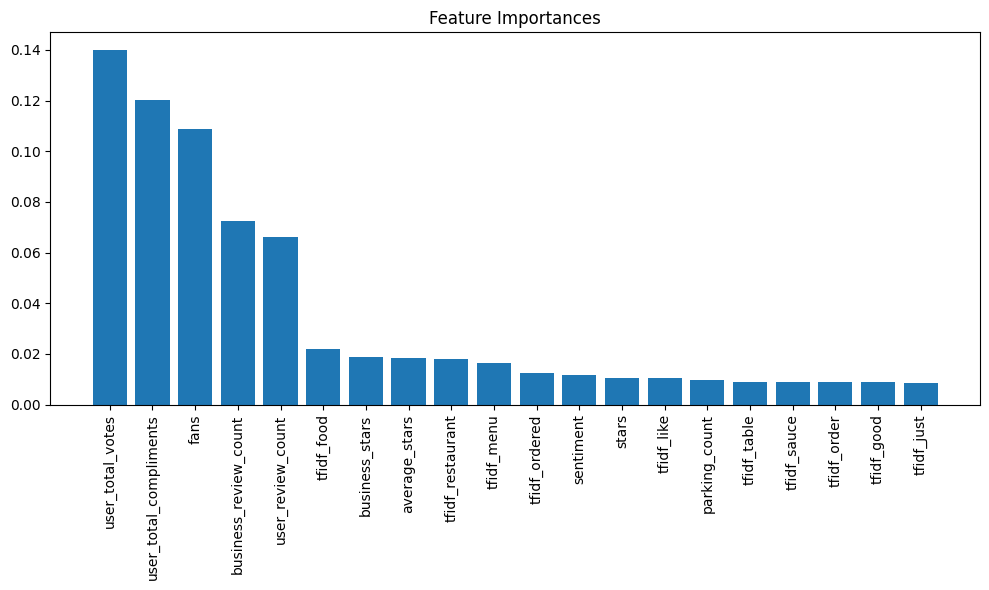

LIME Explanations for 10 Test Instances

--------------------------------------------------------------------------------
Instance 0 - Predicted Class: less useful
Original Text:
this place is the best place in levittown. it dont look like much on the outside or in but the food, service and prices are unbelievable. they only take cash though but it cant be beat. crab cakes are the best i have ever had!!
Top 10 Features and Their Contribution Scores:
                               Feature  Contribution
       user_total_compliments <= -0.90     -0.043791
             user_total_votes <= -0.80     -0.042174
-0.78 < business_review_count <= -0.04     -0.020842
            user_review_count <= -0.80     -0.016646
                      sentiment > 0.60     -0.012076
                 tfidf_online <= -0.13      0.010694
                  tfidf_floor <= -0.14      0.009371
                   tfidf_desk <= -0.12     -0.008449
                 tfidf_issues <= -0.13     -0.008305
                

In [31]:
comprehensive_evaluation(clf_cost_sensitive, X_train_ready, y_train, X_test_ready, y_test,
                         model_type='sklearn', feature_names=original_cols, cv=5, scoring="f1_weighted", n_jobs=-1,
                         original_X_train=X_train, original_X_test=X_test)

In [32]:
adasyn = ADASYN(random_state=42)
X_train_res, y_train_res = adasyn.fit_resample(X_train_ready, y_train)

clf_adasyn = RandomForestClassifier(
    n_estimators=80,
    max_depth=10,
    min_samples_split=10,
    random_state=42
)
clf_adasyn.fit(X_train_res, y_train_res)

RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=80,
                       random_state=42)

Plotting learning curve...


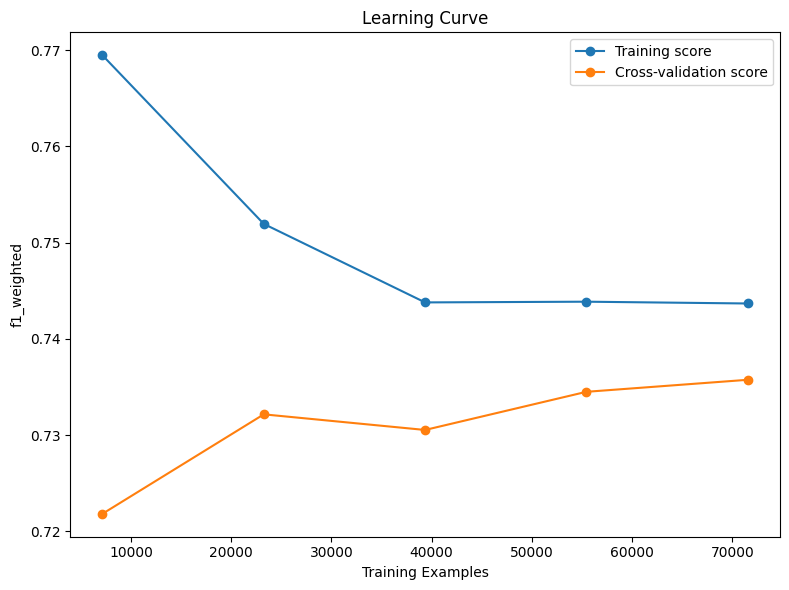


Evaluating on training data:
              precision    recall  f1-score   support

 less useful     0.4770    0.6140    0.5369     20606
 more useful     0.8736    0.7984    0.8343     68818

    accuracy                         0.7559     89424
   macro avg     0.6753    0.7062    0.6856     89424
weighted avg     0.7822    0.7559    0.7658     89424


Evaluating on test data:
              precision    recall  f1-score   support

 less useful     0.4454    0.5685    0.4995      5152
 more useful     0.8591    0.7880    0.8220     17205

    accuracy                         0.7374     22357
   macro avg     0.6523    0.6783    0.6608     22357
weighted avg     0.7638    0.7374    0.7477     22357



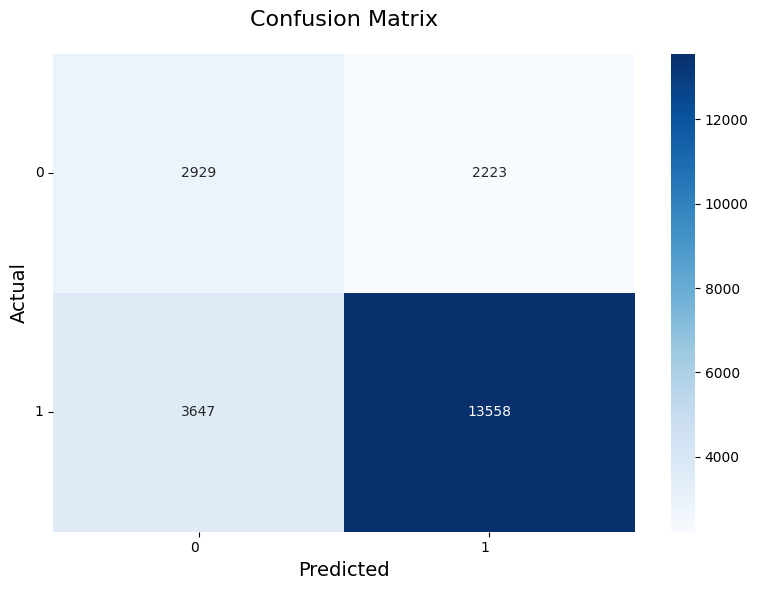

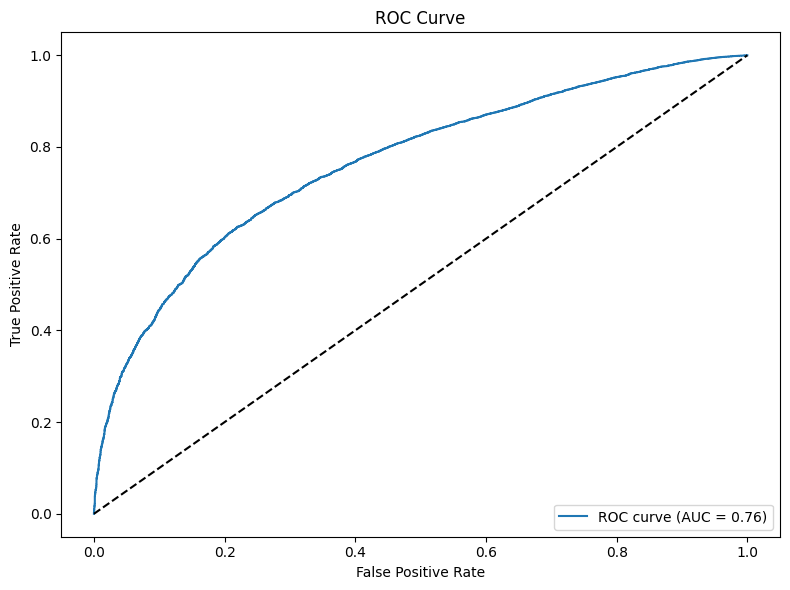

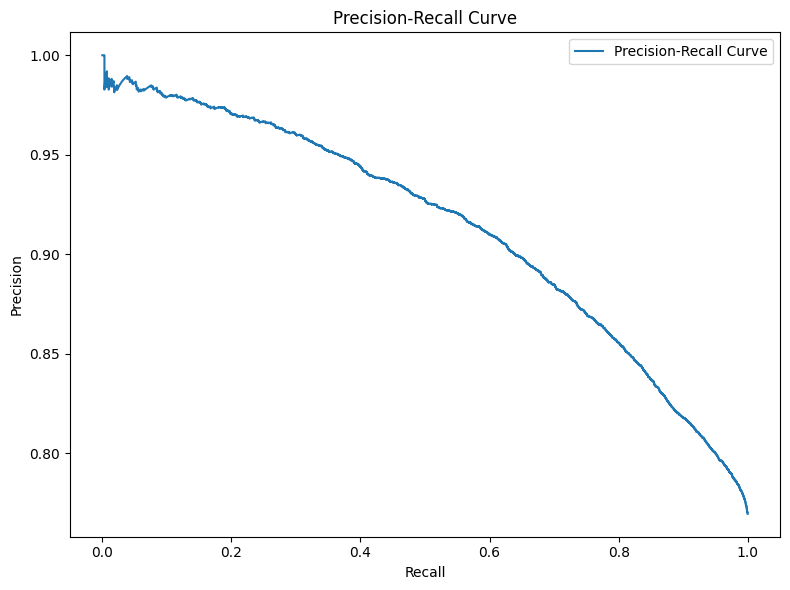

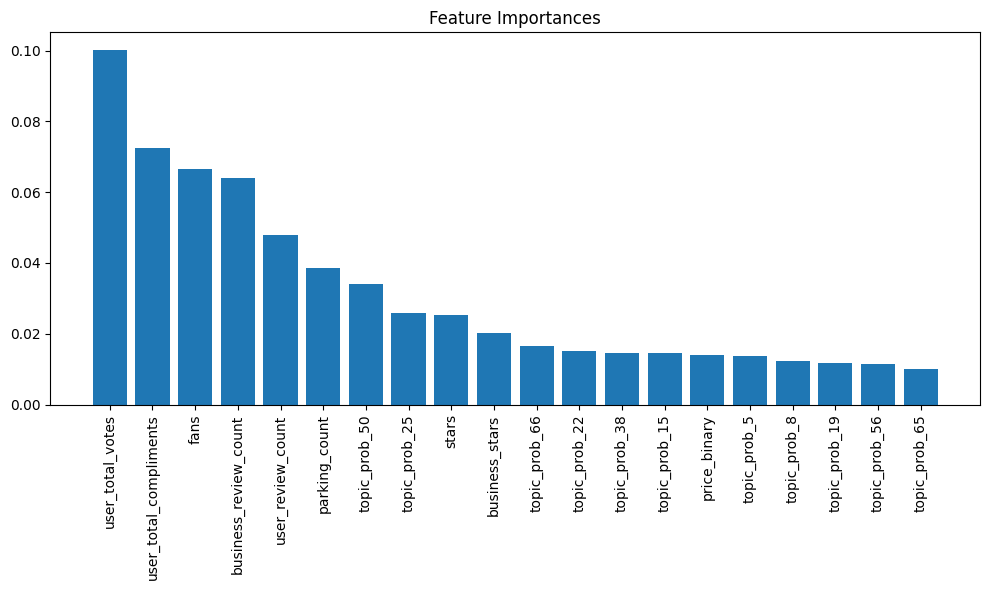

LIME Explanations for 10 Test Instances

--------------------------------------------------------------------------------
Instance 0 - Predicted Class: less useful
Original Text:
this place is the best place in levittown. it dont look like much on the outside or in but the food, service and prices are unbelievable. they only take cash though but it cant be beat. crab cakes are the best i have ever had!!
Top 10 Features and Their Contribution Scores:
                               Feature  Contribution
             user_total_votes <= -0.80     -0.038335
-0.78 < business_review_count <= -0.04     -0.026557
       user_total_compliments <= -0.90     -0.025935
         -1.20 < parking_count <= 0.12      0.021465
            user_review_count <= -0.80     -0.017837
                topic_prob_25 <= -0.07     -0.017783
                         fans <= -1.02     -0.015895
                     tfidf_00 <= -0.12     -0.015698
                  tfidf_liked <= -0.17      0.011539
                

In [33]:
comprehensive_evaluation(clf_adasyn, X_train_ready, y_train, X_test_ready, y_test,
                         model_type='sklearn', feature_names=original_cols, cv=5, scoring="f1_weighted", n_jobs=-1,
                         original_X_train=X_train, original_X_test=X_test)

In [34]:
ada_clf = AdaBoostClassifier(n_estimators=50, random_state=42)
ada_clf.fit(X_train_ready, y_train)

AdaBoostClassifier(random_state=42)

Plotting learning curve...


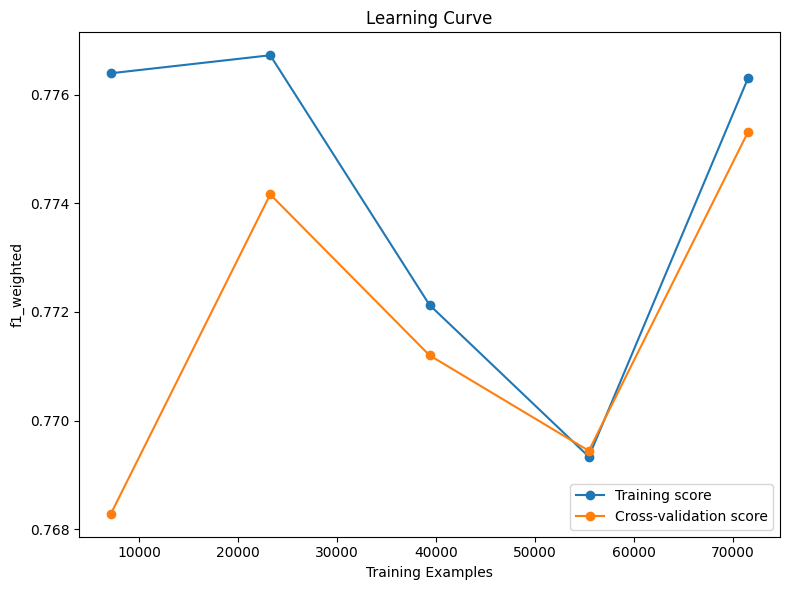


Evaluating on training data:
              precision    recall  f1-score   support

 less useful     0.7668    0.2288    0.3525     20606
 more useful     0.8092    0.9792    0.8861     68818

    accuracy                         0.8063     89424
   macro avg     0.7880    0.6040    0.6193     89424
weighted avg     0.7994    0.8063    0.7631     89424


Evaluating on test data:
              precision    recall  f1-score   support

 less useful     0.7384    0.2224    0.3419      5152
 more useful     0.8075    0.9764    0.8839     17205

    accuracy                         0.8027     22357
   macro avg     0.7729    0.5994    0.6129     22357
weighted avg     0.7915    0.8027    0.7590     22357



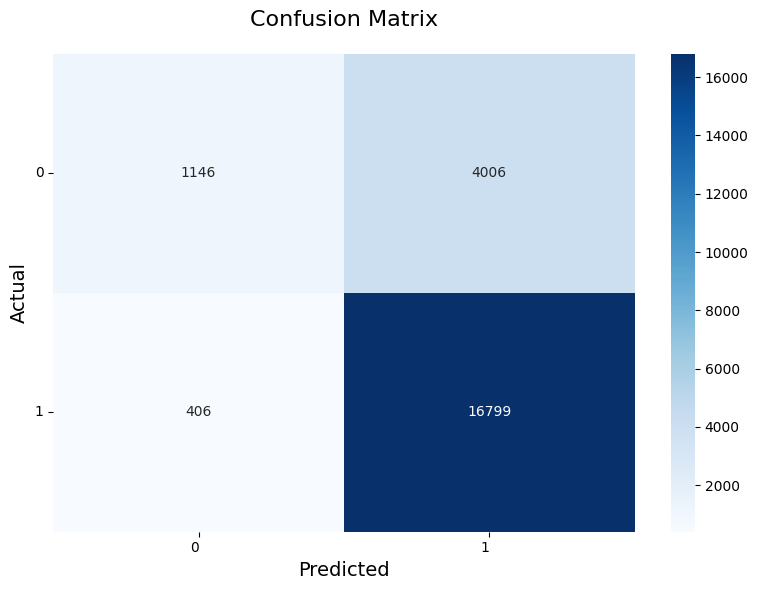

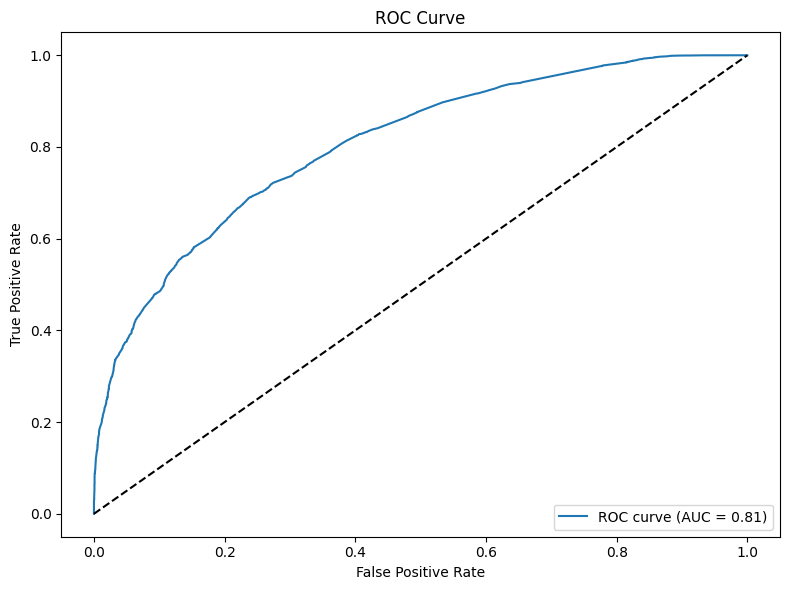

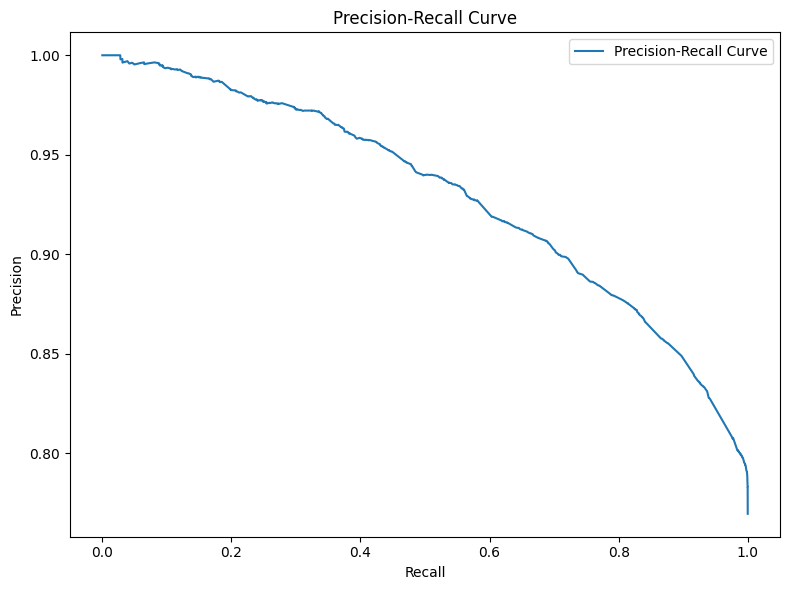

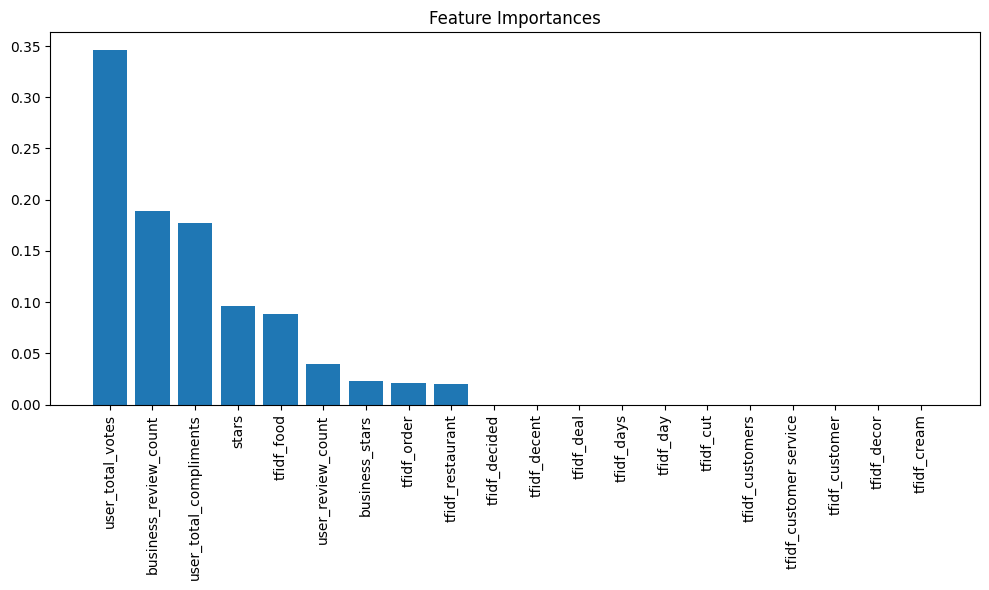

LIME Explanations for 10 Test Instances

--------------------------------------------------------------------------------
Instance 0 - Predicted Class: less useful
Original Text:
this place is the best place in levittown. it dont look like much on the outside or in but the food, service and prices are unbelievable. they only take cash though but it cant be beat. crab cakes are the best i have ever had!!
Top 10 Features and Their Contribution Scores:
                               Feature  Contribution
             user_total_votes <= -0.80     -0.062208
       user_total_compliments <= -0.90     -0.040676
-0.78 < business_review_count <= -0.04     -0.026615
                  0.35 < stars <= 0.98     -0.021474
                   tfidf_live <= -0.18     -0.017544
                    tfidf_guy <= -0.18      0.017260
                 tfidf_waiter <= -0.14      0.016712
                     tfidf_dr <= -0.12     -0.015019
                   tfidf_sign <= -0.14     -0.014937
                

In [35]:
comprehensive_evaluation(ada_clf, X_train_ready, y_train, X_test_ready, y_test,
                         model_type='sklearn', feature_names=original_cols, cv=5, scoring="f1_weighted", n_jobs=-1,
                         original_X_train=X_train, original_X_test=X_test)

In [36]:
from xgboost import XGBClassifier

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train model with best hyperparameters
best_xgb = XGBClassifier(n_estimators=100, min_child_weight=2, reg_alpha=0.1666, reg_lambda=50,
                         subsample=0.60, max_depth=5, learning_rate=0.10, gamma=0.5, colsample_bytree=0.7,
                         random_state=42, eval_metric='logloss')
best_xgb.fit(X_train_ready, y_train_encoded)

# # Predict and convert back to original labels
# y_pred_xgb_encoded = best_xgb.predict(X_test_ready)
# y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb_encoded)

# # Evaluate on test set
# print("XGBoost Classification Report:\n",
#       classification_report(y_test, y_pred_xgb, digits=4))

# # Evaluate on training set
# y_train_pred_xgb_encoded = best_xgb.predict(X_train_ready)
# y_train_pred_xgb = label_encoder.inverse_transform(y_train_pred_xgb_encoded)
# print("Train XGBoost Classification Report:\n",
#       classification_report(y_train, y_train_pred_xgb, digits=4))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Plotting learning curve...


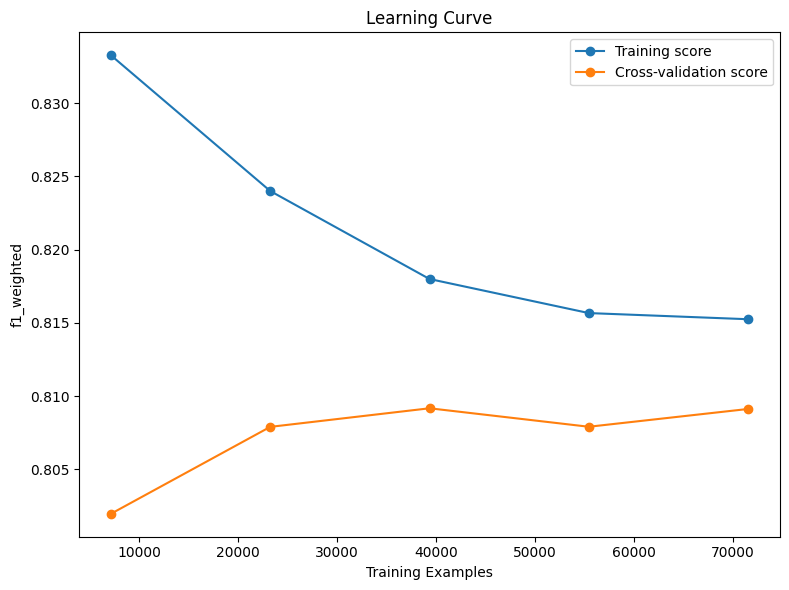


Evaluating on training data:
              precision    recall  f1-score   support

           0     0.7653    0.4019    0.5270     20606
           1     0.8432    0.9631    0.8992     68818

    accuracy                         0.8338     89424
   macro avg     0.8042    0.6825    0.7131     89424
weighted avg     0.8252    0.8338    0.8134     89424


Evaluating on test data:
              precision    recall  f1-score   support

           0     0.7392    0.3868    0.5079      5152
           1     0.8393    0.9591    0.8952     17205

    accuracy                         0.8273     22357
   macro avg     0.7893    0.6730    0.7016     22357
weighted avg     0.8163    0.8273    0.8060     22357



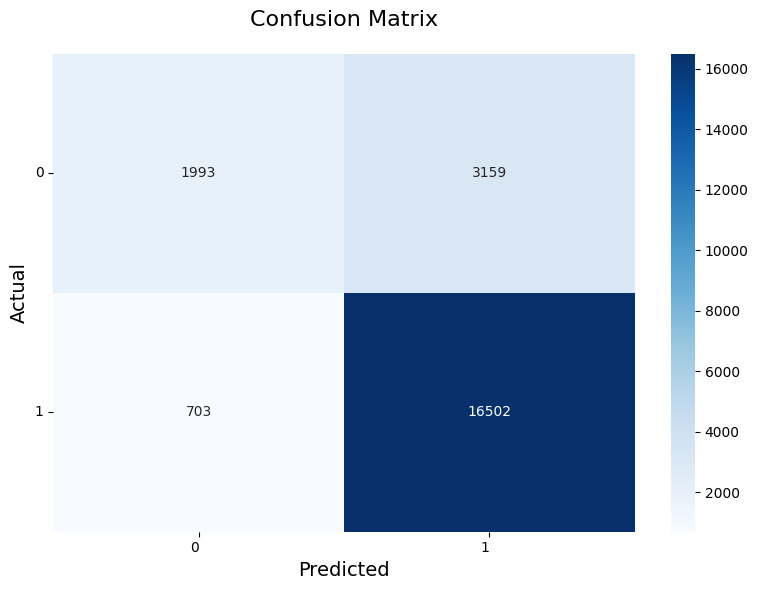

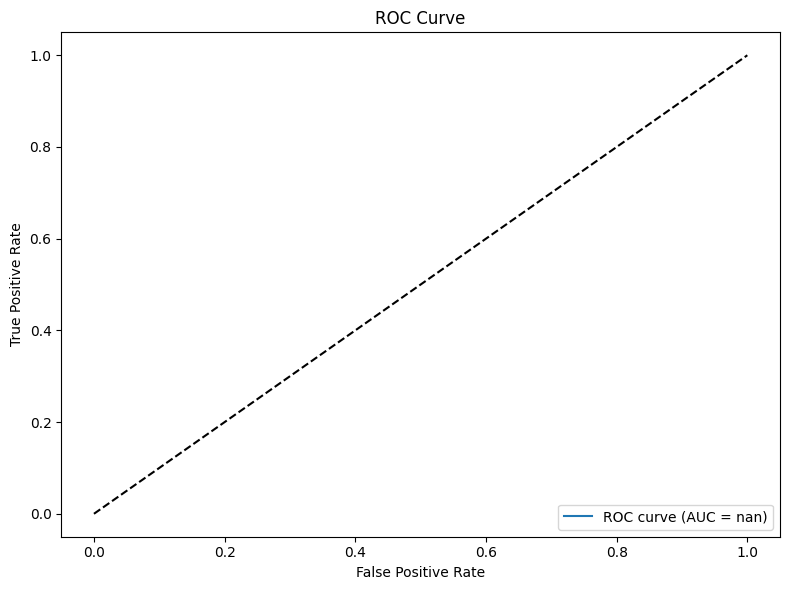

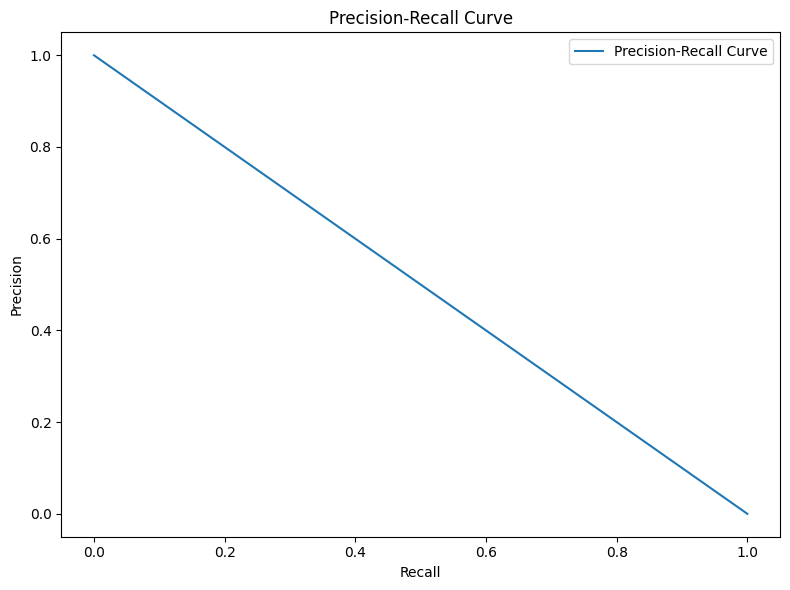

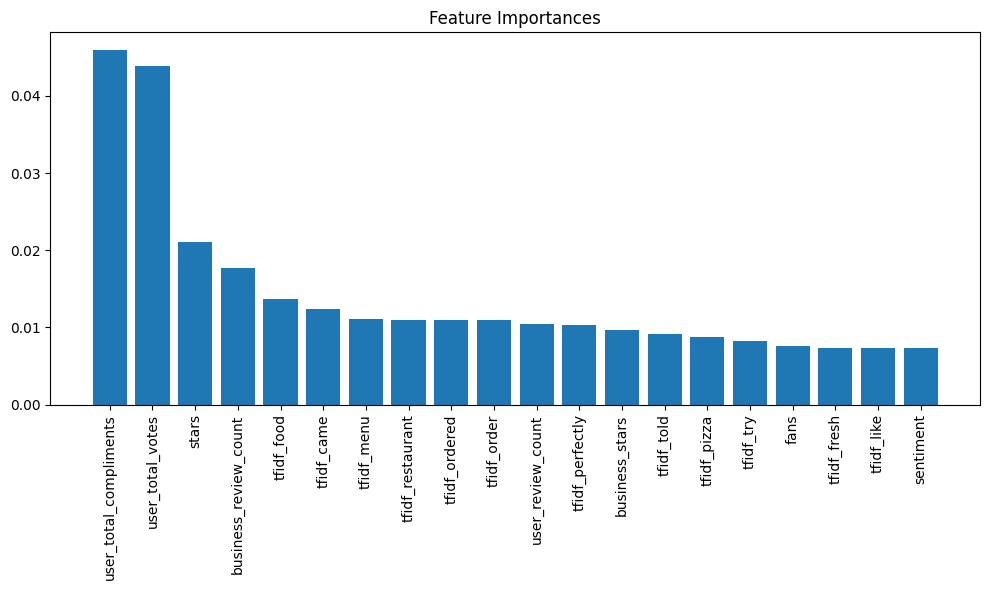

LIME Explanations for 10 Test Instances

--------------------------------------------------------------------------------
Instance 0 - Predicted Class: 0
Original Text:
this place is the best place in levittown. it dont look like much on the outside or in but the food, service and prices are unbelievable. they only take cash though but it cant be beat. crab cakes are the best i have ever had!!
Top 10 Features and Their Contribution Scores:
                               Feature  Contribution
             user_total_votes <= -0.80     -0.265158
            user_review_count <= -0.80      0.073746
       user_total_compliments <= -0.90     -0.057527
                  0.35 < stars <= 0.98     -0.040189
-0.78 < business_review_count <= -0.04     -0.035638
                   tfidf_mind <= -0.17      0.035365
                  tfidf_vegan <= -0.10     -0.032520
                    tfidf_bbq <= -0.13      0.032479
                tfidf_massage <= -0.10     -0.032396
              tfidf_breakf

In [38]:
comprehensive_evaluation(best_xgb, X_train_ready, y_train_encoded, X_test_ready, y_test_encoded,
                         model_type='sklearn', feature_names=original_cols, cv=5, scoring="f1_weighted", n_jobs=-1,
                         original_X_train=X_train, original_X_test=X_test)

## 10. Deep Learning Experiments

The following sections demonstrate deep learning experiments. We tried:
- **Fine-tuned BERT** on the review text.
- **LSTM** networks for sequential text modeling.
- **Multi-Input** architectures that combine numeric and text embedding branches.

### 10.1 BERT Fine-Tuning

Prepare datasets and fine-tune a BERT model using our utility function.

In [43]:
# Prepare train and test datasets for BERT fine-tuning
from datasets import Dataset, DatasetDict

train_df = pd.concat([X_train[['text']].reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
test_df = pd.concat([X_test[['text']].reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
label_mapping = {"less useful": 0, "more useful": 1}
train_df['label'] = train_df['useful_category'].map(label_mapping)
test_df['label'] = test_df['useful_category'].map(label_mapping)

train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])
hf_dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

def tokenize_function(examples):
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

tokenized_datasets = hf_dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")

# Fine-tune BERT using the utility function from deep_learning.py
trainer = finetune_bert(
    train_dataset=tokenized_datasets["train"],
    test_dataset=tokenized_datasets["test"],
    model_path="google-bert/bert-base-uncased",
    output_dir="./bert_finetune_results"
)

Map:   0%|          | 0/89424 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/22357 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: angelinasjw (angelinasjw-ucla) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.544400,0.539915,0.769781,0.769851,0.999709,0.869851
2,0.545300,0.555606,0.769558,0.769558,1.000000,0.869774
3,0.476200,0.479238,0.778280,0.790871,0.967800,0.870436


Evaluation results: {'eval_loss': 0.47923824191093445, 'eval_accuracy': 0.778279733416827, 'eval_precision': 0.7908710933789304, 'eval_recall': 0.9678000581226388, 'eval_f1': 0.8704357144724117, 'eval_runtime': 40.6998, 'eval_samples_per_second': 549.315, 'eval_steps_per_second': 34.349, 'epoch': 3.0}


In [44]:
# Evaluate the fine-tuned BERT model
predictions_output = trainer.predict(tokenized_datasets["test"])
pred_labels = np.argmax(predictions_output.predictions, axis=1)
print("BERT Fine-Tuning Classification Report:")
print(classification_report(predictions_output.label_ids, pred_labels, target_names=["less useful", "more useful"], digits=4))

BERT Fine-Tuning Classification Report:
              precision    recall  f1-score   support

 less useful     0.5748    0.1454    0.2321      5152
 more useful     0.7909    0.9678    0.8704     17205

    accuracy                         0.7783     22357
   macro avg     0.6828    0.5566    0.5513     22357
weighted avg     0.7411    0.7783    0.7233     22357



### 10.2 Keras LSTM Model

Train a Keras LSTM model for text classification using the utility function.

In [45]:
texts = df['text'].astype(str).tolist()
labels = df['useful_category'].tolist()

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(
    texts, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

In [46]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 10000
tokenizer_keras = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer_keras.fit_on_texts(X_text_train)
X_train_seq = tokenizer_keras.texts_to_sequences(X_text_train)
X_test_seq = tokenizer_keras.texts_to_sequences(X_text_test)

max_length = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Build and train the LSTM model using the utility function from deep_learning.py
lstm_model = build_lstm_model(max_words=max_words, max_length=max_length, embedding_dim=64)
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [51]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
lstm_history = lstm_model.fit(
    X_train_pad, y_text_train,
    epochs=10,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 142s 509ms/step - accuracy: 0.7682 - loss: 0.4969 - val_accuracy: 0.7703 - val_loss: 0.4860
Epoch 2/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 140s 501ms/step - accuracy: 0.7683 - loss: 0.4803 - val_accuracy: 0.7703 - val_loss: 0.4806
Epoch 3/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 141s 504ms/step - accuracy: 0.7723 - loss: 0.4678 - val_accuracy: 0.7799 - val_loss: 0.4795
Epoch 4/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 141s 503ms/step - accuracy: 0.7765 - loss: 0.4582 - val_accuracy: 0.7744 - val_loss: 0.4825
Epoch 5/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 140s 500ms/step - accuracy: 0.7878 - loss: 0.4452 - val_accuracy: 0.7718 - val_loss: 0.4871
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 3.


In [52]:
lstm_y_train_pred_probs = lstm_model.predict(X_train_pad)
lstm_y_train_pred = (lstm_y_train_pred_probs > 0.5).astype(int).flatten()
y_true = y_text_train.flatten()
print(classification_report(y_true, lstm_y_train_pred, digits=4))

2795/2795 ━━━━━━━━━━━━━━━━━━━━ 290s 103ms/step
              precision    recall  f1-score   support

           0     0.5726    0.2059    0.3028     20606
           1     0.8005    0.9540    0.8705     68818

    accuracy                         0.7816     89424
   macro avg     0.6866    0.5799    0.5867     89424
weighted avg     0.7480    0.7816    0.7397     89424



In [53]:
comprehensive_evaluation(lstm_model, X_train_pad, y_text_train, X_test_pad, y_text_test, model_type='keras', original_X_test=X_test)


Evaluating deep learning model on test set...
Test evaluation results: [0.4774148464202881, 0.7776535153388977]
699/699 ━━━━━━━━━━━━━━━━━━━━ 72s 103ms/step

Classification Report (Test):
              precision    recall  f1-score   support

           0     0.5502    0.1924    0.2851      5152
           1     0.7976    0.9529    0.8684     17205

    accuracy                         0.7777     22357
   macro avg     0.6739    0.5726    0.5767     22357
weighted avg     0.7406    0.7777    0.7339     22357



### 10.3 Multi-Input Model (Text + Other Features)

This model combines text features (processed via an embedding and LSTM) with additional numeric features.

In [54]:
# Prepare text data (reuse tokenizer)
text_train = X_train['text'].astype(str).tolist()
text_test = X_test['text'].astype(str).tolist()

tokenizer_keras.fit_on_texts(text_train)
X_train_seq = tokenizer_keras.texts_to_sequences(text_train)
X_test_seq = tokenizer_keras.texts_to_sequences(text_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

In [55]:
# Prepare additional features: drop the text column and one-hot encode categoricals
X_train_other = X_train.drop(columns=['text']).copy()
X_test_other = X_test.drop(columns=['text']).copy()
X_train_other = pd.get_dummies(X_train_other, drop_first=True)
X_test_other = pd.get_dummies(X_test_other, drop_first=True)
X_train_other, X_test_other = X_train_other.align(X_test_other, join='inner', axis=1)

In [56]:
scaler = StandardScaler()
X_train_other_scaled = scaler.fit_transform(X_train_other)
X_test_other_scaled = scaler.transform(X_test_other)

In [57]:
# Encode target variable
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [58]:
# Build and train the multi-input model using the utility function
num_other_features = X_train_other_scaled.shape[1]
multi_input_model = build_multi_input_model(max_length=max_length, max_words=max_words, num_other_features=num_other_features, embedding_dim=64)
multi_input_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 200)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 200, 64)        │        640,000 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 64)             │         33,024 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ other_input (InputLayer)  │ (None, 12)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          2,080 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │            416 │ other_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64)             │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │          2,080 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32)             │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1)              │             33 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 677,633 (2.58 MB)

 Trainable params: 677,633 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
history = multi_input_model.fit(
    {'text_input': X_train_pad, 'other_input': X_train_other_scaled},
    y_train_enc,
    epochs=10,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 148s 510ms/step - accuracy: 0.7780 - loss: 0.4817 - val_accuracy: 0.8110 - val_loss: 0.4122
Epoch 2/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 143s 510ms/step - accuracy: 0.8097 - loss: 0.4161 - val_accuracy: 0.8195 - val_loss: 0.3982
Epoch 3/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 141s 505ms/step - accuracy: 0.8179 - loss: 0.3987 - val_accuracy: 0.8197 - val_loss: 0.3977
Epoch 4/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 141s 503ms/step - accuracy: 0.8217 - loss: 0.3846 - val_accuracy: 0.8183 - val_loss: 0.4081
Epoch 5/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 141s 502ms/step - accuracy: 0.8269 - loss: 0.3718 - val_accuracy: 0.8131 - val_loss: 0.4268
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 3.


In [60]:
mi_y_train_pred_probs = multi_input_model.predict({'text_input': X_train_pad, 'other_input': X_train_other_scaled})
mi_y_train_pred = (mi_y_train_pred_probs > 0.5).astype(int).flatten()
y_true = y_text_train.flatten()
print(classification_report(y_true, mi_y_train_pred, digits=4))

2795/2795 ━━━━━━━━━━━━━━━━━━━━ 289s 103ms/step
              precision    recall  f1-score   support

           0     0.7079    0.3989    0.5102     20606
           1     0.8408    0.9507    0.8924     68818

    accuracy                         0.8236     89424
   macro avg     0.7744    0.6748    0.7013     89424
weighted avg     0.8102    0.8236    0.8043     89424




Evaluating deep learning model on test set...
Test evaluation results: [0.40262746810913086, 0.8156282305717468]
699/699 ━━━━━━━━━━━━━━━━━━━━ 72s 103ms/step

Classification Report (Test):
              precision    recall  f1-score   support

           0     0.6789    0.3793    0.4867      5152
           1     0.8358    0.9463    0.8876     17205

    accuracy                         0.8156     22357
   macro avg     0.7574    0.6628    0.6872     22357
weighted avg     0.7997    0.8156    0.7952     22357



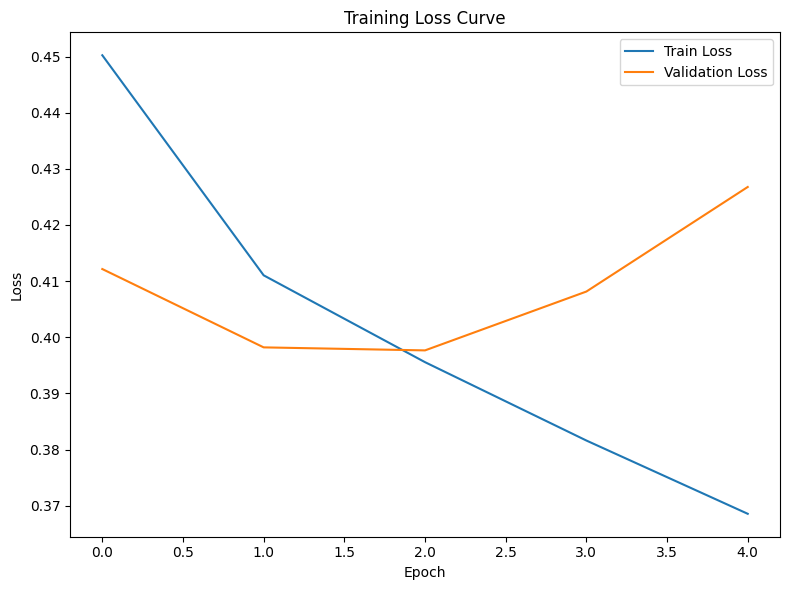

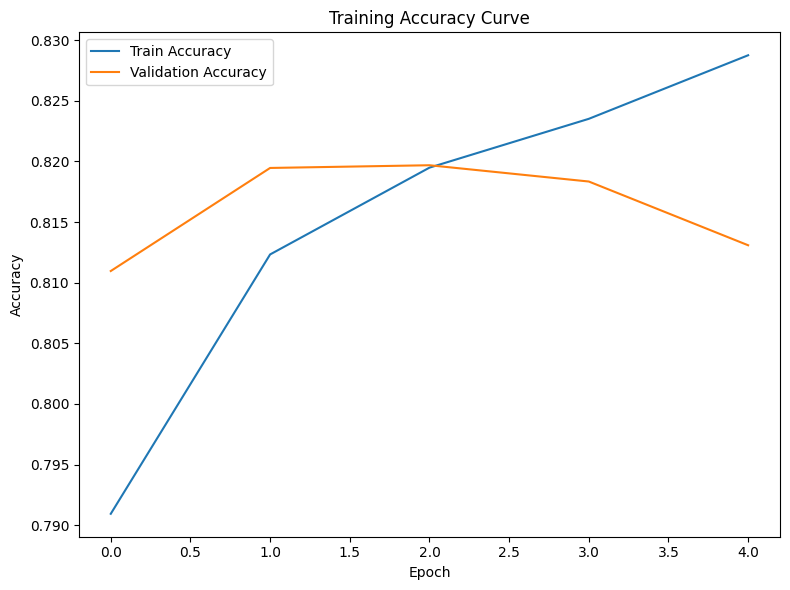

In [61]:
comprehensive_evaluation(multi_input_model, {'text_input': X_train_pad, 'other_input': X_train_other_scaled}, y_text_train, {'text_input': X_test_pad, 'other_input': X_test_other_scaled}, y_text_test, model_type='keras', original_X_test=X_test, history=history)